In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import  precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

c:\Users\Wen2Tee5\Desktop\MLProject\ML\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X_datas = np.load("./timeseries_Datas.npy", allow_pickle=True)
Y_datas = np.load("./dod_Datas.npy", allow_pickle=True)

In [3]:
X_datas.shape

(5152, 7, 37)

In [4]:
train_datasets = TensorDataset(torch.tensor(X_datas, dtype=torch.float32), torch.tensor(Y_datas, dtype=torch.int64)) 
train_datasets.tensors[0].shape
train_datasets[0][0].shape

torch.Size([7, 37])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_datas, Y_datas, test_size=0.2, random_state=42)
X_train.shape

(4121, 7, 37)

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [7]:
train_datasets = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.int64)) 
test_datasets = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.int64)) 
valid_datasets = TensorDataset(torch.tensor(X_valid, dtype=torch.float32), torch.tensor(y_valid, dtype=torch.int64))
train_dataloader = DataLoader(train_datasets, batch_size=len(train_datasets), shuffle=True)
test_dataloader = DataLoader(test_datasets, batch_size=len(test_datasets))
valid_dataloader = DataLoader(valid_datasets, batch_size=len(valid_datasets))

In [8]:
class RNNbased(torch.nn.Module):

    def __init__(self) -> None:
        super(RNNbased, self).__init__()
        self.rnn = torch.nn.RNN(input_size = 37, hidden_size = 37, batch_first = True)
        self.linear = torch.nn.Linear(in_features = 7*37, out_features=2)
    def forward(self, x):
        h, _ = self.rnn(x)
        h = torch.nn.functional.relu(h)
        h = torch.flatten(h, start_dim = 1)
        out = self.linear(h)
        return out
    
class LSTMbased(torch.nn.Module):

    def __init__(self) -> None:
        super(LSTMbased, self).__init__()
        self.lstm = torch.nn.LSTM(input_size = 37, hidden_size = 37, batch_first = True)
        self.linear = torch.nn.Linear(in_features = 7*37, out_features=2)
    def forward(self, x):
        h, (_,_) = self.lstm(x)
        h = torch.nn.functional.relu(h)
        h = torch.flatten(h, start_dim = 1)
        out = self.linear(h)
        return out
    
class GRUbased(torch.nn.Module):

    def __init__(self) -> None:
        super(GRUbased, self).__init__()
        self.gru = torch.nn.GRU(input_size = 37, hidden_size = 37, batch_first = True)
        self.linear = torch.nn.Linear(in_features = 7*37, out_features=2)
    def forward(self, x):
        h, _ = self.gru(x)
        h = torch.nn.functional.relu(h)
        h = torch.flatten(h, start_dim = 1)
        out = self.linear(h)
        return out

class BI_RNNbased(torch.nn.Module):

    def __init__(self) -> None:
        super(BI_RNNbased, self).__init__()
        self.bi_rnn = torch.nn.RNN(input_size = 37, hidden_size = 37, batch_first = True, bidirectional = True)
        self.linear = torch.nn.Linear(in_features = 7 * 2 * 37, out_features=2)
    def forward(self, x):
        h, _ = self.bi_rnn(x)
        h = torch.nn.functional.relu(h)
        h = torch.flatten(h, start_dim = 1)
        out = self.linear(h)
        return out
    
class BI_LSTMbased(torch.nn.Module):

    def __init__(self) -> None:
        super(BI_LSTMbased, self).__init__()
        self.bi_lstm = torch.nn.LSTM(input_size = 37, hidden_size = 37, batch_first = True, bidirectional = True)
        self.linear = torch.nn.Linear(in_features = 7 * 2 * 37, out_features=2)
    def forward(self, x):
        h, (_,_)  = self.bi_lstm(x)
        h = torch.nn.functional.relu(h)
        h = torch.flatten(h, start_dim = 1)
        out = self.linear(h)
        return out

class BI_GRUbased(torch.nn.Module):

    def __init__(self) -> None:
        super(BI_GRUbased, self).__init__()
        self.bi_gru = torch.nn.GRU(input_size = 37, hidden_size = 37, batch_first = True, bidirectional = True)
        self.linear = torch.nn.Linear(in_features = 7 * 2 * 37, out_features=2)
    def forward(self, x):
        h, _ = self.bi_gru(x)
        h = torch.nn.functional.relu(h)
        h = torch.flatten(h, start_dim = 1)
        out = self.linear(h)
        return out

In [9]:
train_losses = []
test_losses = []
val_losses = []

In [10]:
def epoch(model, optimizer, loss_fn):
    for epoch in range(200):
        model.train()
        total_loss = 0.
        train_process = tqdm(train_dataloader)
        val_process = tqdm(valid_dataloader)
        for batch, (x, y) in enumerate(train_process, start=1):
            x,y = x.cuda(),y.cuda()
            optimizer.zero_grad()
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            train_process.set_postfix({"EPOCH" : epoch ,"AVG_LOSS": total_loss / batch})
        train_losses.append(total_loss / batch)
        with torch.no_grad():
            model.eval()
            for x, y in val_process:
                x,y = x.cuda(),y.cuda()
                y_pred = model(x)
                # Compute loss
                loss = loss_fn(y_pred, y)
                val_losses.append(loss.item())
            
            accuracy = 0
            count = 0
            model.eval()
            x,y = next(iter(test_dataloader))
            x,y = x.cuda(),y.cuda()
            y_pred = model(x)

            _, predicted = torch.max(y_pred.data, 1)
            count += len(x)
            accuracy += (predicted == y).sum().item()
            
            pre = precision_score(y.cpu() ,predicted.cpu(), average = 'macro')
            f1 = f1_score(y.cpu() ,predicted.cpu(), average = 'macro')
            recall = recall_score(y.cpu() ,predicted.cpu(), average = 'macro')
            
            print("Accuracy: {}".format(accuracy / count))
            print("Precision: {}".format(pre))
            print("Recall: {}".format(recall))
            print("f1_score: {}".format(f1))


In [11]:
#RNNbased, LSTMbased, GRUbased, BI_RNNbased, BI_LSTMbased, BI_GRUbased
RNNmodel = RNNbased().cuda()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(RNNmodel.parameters(), lr=1e-3)
epoch(RNNmodel, optimizer, loss_fn)

100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


Accuracy: 0.5916585838991271
Precision: 0.5961825878178364
Recall: 0.5754515748388853
f1_score: 0.5596417487675983


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.5809893307468477
Precision: 0.611905478627333
Recall: 0.5562388430002119
f1_score: 0.5063048683160415


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.5790494665373423
Precision: 0.6015087879795964
Recall: 0.5553935584399867
f1_score: 0.5108380997358801


100%|██████████| 1/1 [00:00<00:00, 35.07it/s]


Accuracy: 0.6013579049466538
Precision: 0.617920534114965
Recall: 0.5821627938640284
f1_score: 0.5582704474307213


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.623666343355965
Precision: 0.6324576372260295
Recall: 0.6092081177574051
f1_score: 0.5991446345256609


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6333656644034917
Precision: 0.6393070385704946
Recall: 0.620888929230583
f1_score: 0.6146868993664428


100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


Accuracy: 0.6304558680892337
Precision: 0.6363831483412032
Recall: 0.6177574052222323
f1_score: 0.6111017057385644


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6314258001939864
Precision: 0.639304215791354
Recall: 0.6179729811503434
f1_score: 0.610122601703686


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.635305528612997
Precision: 0.6450322901142573
Recall: 0.6214581253214728
f1_score: 0.6130992303024496


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6343355965082444
Precision: 0.6422283221846157
Recall: 0.6211045051586942
f1_score: 0.6137529227867561


100%|██████████| 1/1 [00:00<00:00, 32.25it/s]


Accuracy: 0.6333656644034917
Precision: 0.6381467427312699
Recall: 0.6214411061692535
f1_score: 0.6160413793103447


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6430649854510184
Precision: 0.6464585056866137
Recall: 0.6325697407037609
f1_score: 0.6292526579111946


100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


Accuracy: 0.6362754607177498
Precision: 0.6379667021777371
Recall: 0.6263672052282836
f1_score: 0.6234884760449564


100%|██████████| 1/1 [00:00<00:00, 35.08it/s]


Accuracy: 0.6372453928225025
Precision: 0.6389308160538427
Recall: 0.6274110465644005
f1_score: 0.6246310501927494


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6343355965082444
Precision: 0.6364440282979609
Recall: 0.6240034340867144
f1_score: 0.6206247651396474


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


Accuracy: 0.6333656644034917
Precision: 0.6356890370778912
Recall: 0.6228215485159299
f1_score: 0.6191780018761726


100%|██████████| 1/1 [00:00<00:00, 43.46it/s]


Accuracy: 0.6343355965082444
Precision: 0.6371009020348227
Recall: 0.6235893013827116
f1_score: 0.6197384550514256


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


Accuracy: 0.6391852570320078
Precision: 0.6419201600133344
Recall: 0.6288085080632961
f1_score: 0.6255126192205844


100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


Accuracy: 0.6391852570320078
Precision: 0.6410567295161742
Recall: 0.6293606850019666
f1_score: 0.626638370779954


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6401551891367604
Precision: 0.6422239014278753
Recall: 0.630266482103416
f1_score: 0.6275045989671435


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6391852570320078
Precision: 0.6402842440578289
Recall: 0.6299128619406372
f1_score: 0.6277111240535818


100%|██████████| 1/1 [00:00<00:00, 34.48it/s]


Accuracy: 0.6411251212415131
Precision: 0.6423895287102834
Recall: 0.6318625003782034
f1_score: 0.629712677150068


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6430649854510184
Precision: 0.6446896568663572
Recall: 0.6336740945811019
f1_score: 0.6314537937894377


100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


Accuracy: 0.6391852570320078
Precision: 0.6404690557479593
Recall: 0.6297748177059695
f1_score: 0.6274478567654098


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6440349175557711
Precision: 0.645645418489594
Recall: 0.6347179359172188
f1_score: 0.6325855450911163


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6411251212415131
Precision: 0.6425793563071582
Recall: 0.6317244561435358
f1_score: 0.6294508252774238


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6459747817652765
Precision: 0.6477531994929877
Recall: 0.6366675743547849
f1_score: 0.634587803700974


100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


Accuracy: 0.6479146459747818
Precision: 0.6492650641546207
Recall: 0.6390313454963541
f1_score: 0.6373464730592016


100%|██████████| 1/1 [00:00<00:00, 36.35it/s]


Accuracy: 0.6450048496605237
Precision: 0.6458572769801059
Recall: 0.6363139541920063
f1_score: 0.6347199312315592


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.646944713870029
Precision: 0.6477670098929942
Recall: 0.6384016368642401
f1_score: 0.6369577835390627


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


Accuracy: 0.6498545101842871
Precision: 0.6509802732638047
Recall: 0.6412570724032556
f1_score: 0.6398303813613038


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6517943743937924
Precision: 0.6528791777926573
Recall: 0.6433447550754894
f1_score: 0.6420627022970598


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6517943743937924
Precision: 0.6528791777926573
Recall: 0.6433447550754894
f1_score: 0.6420627022970598


100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


Accuracy: 0.6547041707080504
Precision: 0.6560932768019383
Recall: 0.6462001906145048
f1_score: 0.6449367333513911


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


Accuracy: 0.6595538312318138
Precision: 0.6613994664079554
Recall: 0.6510052645910864
f1_score: 0.6498073791075281


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6547041707080504
Precision: 0.6560932768019383
Recall: 0.6462001906145048
f1_score: 0.6449367333513911


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6614936954413191
Precision: 0.6623291335313468
Recall: 0.6537831684366584
f1_score: 0.6531400351468775


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


Accuracy: 0.6605237633365665
Precision: 0.661214673717964
Recall: 0.6528773713352092
f1_score: 0.6522531030760929


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6682832201745877
Precision: 0.6696271579283888
Recall: 0.6605378808508063
f1_score: 0.6599919000231428


100%|██████████| 1/1 [00:00<00:00, 34.47it/s]


Accuracy: 0.6711930164888458
Precision: 0.672427463761764
Recall: 0.663669404859157
f1_score: 0.6632851540033353


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


Accuracy: 0.6721629485935985
Precision: 0.6739502999143101
Recall: 0.664299113491271
f1_score: 0.6637585006445437


100%|██████████| 1/1 [00:00<00:00, 37.72it/s]


Accuracy: 0.6721629485935985
Precision: 0.6737472026854221
Recall: 0.6644371577259387
f1_score: 0.6639686029468488


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6731328806983511
Precision: 0.6741090920637944
Recall: 0.6658951317660585
f1_score: 0.665673638073794


100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


Accuracy: 0.6779825412221144
Precision: 0.6793200581649437
Recall: 0.6707002057426401
f1_score: 0.670536009917839


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6750727449078564
Precision: 0.6756320368878994
Recall: 0.6682589029076276
f1_score: 0.6682362252979424


100%|██████████| 1/1 [00:00<00:00, 37.72it/s]


Accuracy: 0.6731328806983511
Precision: 0.673139311103256
Recall: 0.6667233971740643
f1_score: 0.6668124284975887


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6750727449078564
Precision: 0.6754699507389162
Recall: 0.6683969471422953
f1_score: 0.6684235032088667


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


Accuracy: 0.6750727449078564
Precision: 0.675974643423138
Recall: 0.6679828144382923
f1_score: 0.6678533682996797


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


Accuracy: 0.6789524733268671
Precision: 0.6798776388328627
Recall: 0.6720201355480924
f1_score: 0.6720098110356851


100%|██████████| 1/1 [00:00<00:00, 10.36it/s]

Accuracy: 0.6760426770126091


Precision: 0.6764060826560827
Recall: 0.6694407884784122
f1_score: 0.6695056126287987


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6799224054316197
Precision: 0.6803040904409625
Recall: 0.6734781095882121
f1_score: 0.6736440443851006


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6808923375363725
Precision: 0.6813981210461713
Recall: 0.6743839066896614
f1_score: 0.674543404735062


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6847720659553831
Precision: 0.6849724786445244
Recall: 0.6786973162687967
f1_score: 0.679021416453607


100%|██████████| 1/1 [00:00<00:00, 39.85it/s]


Accuracy: 0.6896217264791464
Precision: 0.6896399769135976
Recall: 0.6839165229493812
f1_score: 0.6843692359500684


100%|██████████| 1/1 [00:00<00:00, 38.41it/s]


Accuracy: 0.6896217264791464
Precision: 0.6899389766859647
Recall: 0.683640434480046
f1_score: 0.6840427814041863


100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


Accuracy: 0.6935014548981572
Precision: 0.694137536535101
Recall: 0.6874016671205108
f1_score: 0.6878272201142156


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


Accuracy: 0.6905916585838991
Precision: 0.6913612976709477
Recall: 0.6842701431121601
f1_score: 0.6846087973018717


100%|██████████| 1/1 [00:00<00:00, 43.46it/s]


Accuracy: 0.6954413191076625
Precision: 0.6958264007686359
Recall: 0.6896273940274122
f1_score: 0.6901284152168586


100%|██████████| 1/1 [00:00<00:00, 37.72it/s]


Accuracy: 0.6973811833171678
Precision: 0.6976812204595442
Recall: 0.691715076699646
f1_score: 0.6922600050513168


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6944713870029098
Precision: 0.6939345277251093
Recall: 0.6895498623339688
f1_score: 0.690132499806789


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


Accuracy: 0.6935014548981572
Precision: 0.6932420889147739
Recall: 0.6882299325285165
f1_score: 0.6887790973145642


100%|██████████| 1/1 [00:00<00:00, 37.02it/s]


Accuracy: 0.6964112512124151
Precision: 0.6967537485267372
Recall: 0.6906712353635291
f1_score: 0.6911947789723494


100%|██████████| 1/1 [00:00<00:00, 27.77it/s]

Accuracy: 0.6954413191076625


Precision: 0.6953795726017171
Recall: 0.6900415267314151
f1_score: 0.6905975227463874


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6944713870029098
Precision: 0.6938222655042354
Recall: 0.6896879065686363
f1_score: 0.690275529988241


100%|██████████| 1/1 [00:00<00:00, 32.77it/s]


Accuracy: 0.6954413191076625
Precision: 0.6947639166737469
Recall: 0.6907317479047532
f1_score: 0.6913291380625477


100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


Accuracy: 0.6993210475266731
Precision: 0.699111698745289
Recall: 0.6942168920758827
f1_score: 0.6948352773131068


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6954413191076625
Precision: 0.69524364201126
Recall: 0.6901795709660827
f1_score: 0.6907488498632063


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6964112512124151
Precision: 0.6959292651781914
Recall: 0.691499500771535
f1_score: 0.6920999125064284


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.7002909796314258
Precision: 0.6999187400843556
Recall: 0.6953987776466672
f1_score: 0.6960347379057074


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6935014548981572
Precision: 0.6926714495101443
Recall: 0.6889201537018548
f1_score: 0.6895028171913479


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6915615906886518
Precision: 0.6905901116427433
Recall: 0.6871085594989561
f1_score: 0.6876757584764169


100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


Accuracy: 0.6915615906886518
Precision: 0.6906830980482912
Recall: 0.6869705152642885
f1_score: 0.6875376451482551


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6925315227934045
Precision: 0.6921778605517401
Recall: 0.6873241354270673
f1_score: 0.6878696571911544


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6905916585838991
Precision: 0.6903033788194337
Recall: 0.6852364527548335
f1_score: 0.6857479191688716


100%|██████████| 1/1 [00:00<00:00, 37.02it/s]


Accuracy: 0.6944713870029098
Precision: 0.6937162772387282
Recall: 0.689825950803304
f1_score: 0.6904160673074449


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6935014548981572
Precision: 0.6924867635289047
Recall: 0.6891962421711899
f1_score: 0.6897748221277633


100%|██████████| 1/1 [00:00<00:00, 32.25it/s]


Accuracy: 0.6915615906886518
Precision: 0.6906830980482912
Recall: 0.6869705152642885
f1_score: 0.6875376451482551


100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


Accuracy: 0.6925315227934045
Precision: 0.6920556872956092
Recall: 0.6874621796617348
f1_score: 0.6880186333328561


100%|██████████| 1/1 [00:00<00:00, 43.46it/s]


Accuracy: 0.6935014548981572
Precision: 0.6928808971384377
Recall: 0.6886440652325194
f1_score: 0.6892208485958486


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6925315227934045
Precision: 0.6913013950918551
Recall: 0.688566533539076
f1_score: 0.6891202010468973


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6925315227934045
Precision: 0.6913013950918551
Recall: 0.688566533539076
f1_score: 0.6891202010468973


100%|██████████| 1/1 [00:00<00:00, 40.79it/s]


Accuracy: 0.6925315227934045
Precision: 0.6917266825679859
Recall: 0.6878763123657379
f1_score: 0.688450455036381


100%|██████████| 1/1 [00:00<00:00, 35.71it/s]


Accuracy: 0.6896217264791464
Precision: 0.6887913522364773
Recall: 0.6848828325920546
f1_score: 0.6854309687261633


100%|██████████| 1/1 [00:00<00:00, 35.71it/s]


Accuracy: 0.6867119301648884
Precision: 0.6853676504443114
Recall: 0.6827176182263774
f1_score: 0.6832360408143465


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


Accuracy: 0.6847720659553831
Precision: 0.6833314169637039
Recall: 0.6809060240234789
f1_score: 0.6814043595046233


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6896217264791464
Precision: 0.688604196041267
Recall: 0.68515892106139
f1_score: 0.6857114550706083


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6905916585838991
Precision: 0.6897370878972435
Recall: 0.6859266739281716
f1_score: 0.6864848427653172


100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


Accuracy: 0.6935014548981572
Precision: 0.692326592036363
Recall: 0.6894723306405253
f1_score: 0.690036914411843


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6925315227934045
Precision: 0.6911736553540799
Recall: 0.6888426220084112
f1_score: 0.6893707616345657


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


Accuracy: 0.6915615906886518
Precision: 0.6905901116427433
Recall: 0.6871085594989561
f1_score: 0.6876757584764169


100%|██████████| 1/1 [00:00<00:00, 38.33it/s]


Accuracy: 0.6886517943743938
Precision: 0.6878458696593087
Recall: 0.6838389912559377
f1_score: 0.6843760162737313


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6886517943743938
Precision: 0.6875688204085719
Recall: 0.6842531239599408
f1_score: 0.6847980646973947


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6896217264791464
Precision: 0.6883019519116462
Recall: 0.6857110980000605
f1_score: 0.6862422872967688


100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


Accuracy: 0.6915615906886518
Precision: 0.6904223836427226
Recall: 0.6873846479682915
f1_score: 0.6879444909769283


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6905916585838991
Precision: 0.6898380016076177
Recall: 0.685788629693504
f1_score: 0.6863425208452345


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6935014548981572
Precision: 0.6925760272442194
Recall: 0.6890581979365223
f1_score: 0.6896400618822257


100%|██████████| 1/1 [00:00<00:00, 33.32it/s]


Accuracy: 0.6896217264791464
Precision: 0.688241242989795
Recall: 0.6858491422347281
f1_score: 0.6863687524716333


100%|██████████| 1/1 [00:00<00:00, 32.25it/s]


Accuracy: 0.6896217264791464
Precision: 0.6884411391675314
Recall: 0.6854350095307252
f1_score: 0.6859818777126323


100%|██████████| 1/1 [00:00<00:00, 37.72it/s]


Accuracy: 0.6876818622696411
Precision: 0.6864598946923403
Recall: 0.683485371093159
f1_score: 0.6840192644483363


100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


Accuracy: 0.6886517943743938
Precision: 0.6871753681392236
Recall: 0.6850813893679466
f1_score: 0.6855742729372376


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6828322017458778
Precision: 0.6811087272422949
Recall: 0.6800607394632537
f1_score: 0.6803967536955106


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6828322017458778
Precision: 0.6812210555275345
Recall: 0.6793705182899156
f1_score: 0.6798200503152538


100%|██████████| 1/1 [00:00<00:00, 39.94it/s]


Accuracy: 0.6876818622696411
Precision: 0.6865361232530937
Recall: 0.6833473268584914
f1_score: 0.6838844706491766


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6808923375363725
Precision: 0.6793314291840236
Recall: 0.6771447913830142
f1_score: 0.6776119261128456


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6828322017458778
Precision: 0.6812602792120864
Recall: 0.679232474055248
f1_score: 0.6796971565435411


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6847720659553831
Precision: 0.6834538177292597
Recall: 0.6806299355541436
f1_score: 0.6811424156001602


100%|██████████| 1/1 [00:00<00:00, 36.56it/s]


Accuracy: 0.6905916585838991
Precision: 0.6893234802093405
Recall: 0.6866168951015097
f1_score: 0.6871588143027137


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6876818622696411
Precision: 0.6860604304698876
Recall: 0.6845897249705002
f1_score: 0.6850074387818615


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6828322017458778
Precision: 0.6811087272422949
Recall: 0.6800607394632537
f1_score: 0.6803967536955106


100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


Accuracy: 0.6857419980601358
Precision: 0.6841231684981685
Recall: 0.6825020422982664
f1_score: 0.6829354412501708


100%|██████████| 1/1 [00:00<00:00, 37.84it/s]


Accuracy: 0.6915615906886518
Precision: 0.6903475837287512
Recall: 0.687522692202959
f1_score: 0.6880751227309053


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6896217264791464
Precision: 0.6884411391675314
Recall: 0.6854350095307252
f1_score: 0.6859818777126323


100%|██████████| 1/1 [00:00<00:00, 32.77it/s]


Accuracy: 0.6886517943743938
Precision: 0.6873455653268259
Recall: 0.6846672566639436
f1_score: 0.68519742755853


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6905916585838991
Precision: 0.6891470644482693
Recall: 0.6870310278055127
f1_score: 0.6875333117351365


100%|██████████| 1/1 [00:00<00:00, 33.33it/s]


Accuracy: 0.6896217264791464
Precision: 0.688241242989795
Recall: 0.6858491422347281
f1_score: 0.6863687524716333


100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


Accuracy: 0.6847720659553831
Precision: 0.6832319755211321
Recall: 0.6811821124928141
f1_score: 0.68165619534144


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6847720659553831
Precision: 0.6831012749872349
Recall: 0.6817342894314846
f1_score: 0.6821297284477648


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


Accuracy: 0.6886517943743938
Precision: 0.6871303131734605
Recall: 0.6852194336026142
f1_score: 0.6856949117773593


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6867119301648884
Precision: 0.6852525422690517
Recall: 0.6829937066957127
f1_score: 0.6834913438737056


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6867119301648884
Precision: 0.6852036718301778
Recall: 0.6831317509303804
f1_score: 0.6836152341393387


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6876818622696411
Precision: 0.6862137319281488
Recall: 0.6840375480318297
f1_score: 0.6845333120476799


100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


Accuracy: 0.6857419980601358
Precision: 0.6841960394525575
Recall: 0.682225953828931
f1_score: 0.6826969109768608


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6867119301648884
Precision: 0.6852525422690517
Recall: 0.6829937066957127
f1_score: 0.6834913438737056


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


Accuracy: 0.6847720659553831
Precision: 0.6832319755211321
Recall: 0.6811821124928141
f1_score: 0.68165619534144


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6867119301648884
Precision: 0.6851605606248186
Recall: 0.6832697951650479
f1_score: 0.6837366246233241


100%|██████████| 1/1 [00:00<00:00, 37.71it/s]


Accuracy: 0.6857419980601358
Precision: 0.6841567558071144
Recall: 0.6823639980635987
f1_score: 0.6828174256523225


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6867119301648884
Precision: 0.6852036718301778
Recall: 0.6831317509303804
f1_score: 0.6836152341393387


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6876818622696411
Precision: 0.6862665103735711
Recall: 0.683899503797162
f1_score: 0.684408557174581


100%|██████████| 1/1 [00:00<00:00, 38.33it/s]


Accuracy: 0.6867119301648884
Precision: 0.6851605606248186
Recall: 0.6832697951650479
f1_score: 0.6837366246233241


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


Accuracy: 0.6896217264791464
Precision: 0.6880943651321065
Recall: 0.6862632749387311
f1_score: 0.6867332599035284


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6857419980601358
Precision: 0.6842917777573473
Recall: 0.6819498653595958
f1_score: 0.6824483618775287


100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


Accuracy: 0.6915615906886518
Precision: 0.6904223836427226
Recall: 0.6873846479682915
f1_score: 0.6879444909769283


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6857419980601358
Precision: 0.6842917777573473
Recall: 0.6819498653595958
f1_score: 0.6824483618775287


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6896217264791464
Precision: 0.6880570818070818
Recall: 0.6864013191733986
f1_score: 0.6868498185186873


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6915615906886518
Precision: 0.6899417741751341
Recall: 0.6887650903149678
f1_score: 0.6891398338832632


100%|██████████| 1/1 [00:00<00:00, 28.97it/s]


Accuracy: 0.6828322017458778
Precision: 0.681159420289855
Recall: 0.6796466067592508
f1_score: 0.6800582683666351


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6876818622696411
Precision: 0.6863251140852091
Recall: 0.6837614595624943
f1_score: 0.6842813015923737


100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


Accuracy: 0.6886517943743938
Precision: 0.6870910603989953
Recall: 0.6853574778372817
f1_score: 0.6858130719214853


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6905916585838991
Precision: 0.689023646071701
Recall: 0.6874451605095155
f1_score: 0.6878855890182161


100%|██████████| 1/1 [00:00<00:00, 43.37it/s]


Accuracy: 0.6876818622696411
Precision: 0.6863251140852091
Recall: 0.6837614595624943
f1_score: 0.6842813015923737


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6905916585838991
Precision: 0.6891000657221025
Recall: 0.6871690720401804
f1_score: 0.6876531989313945


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6876818622696411
Precision: 0.6860056125087458
Recall: 0.685003857674503
f1_score: 0.6853370488322719


100%|██████████| 1/1 [00:00<00:00, 40.79it/s]


Accuracy: 0.6896217264791464
Precision: 0.6880570818070818
Recall: 0.6864013191733986
f1_score: 0.6868498185186873


100%|██████████| 1/1 [00:00<00:00, 13.15it/s]


Accuracy: 0.6925315227934045
Precision: 0.6910268058238344
Recall: 0.6892567547124142
f1_score: 0.6897281738290058


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6925315227934045
Precision: 0.6909136557642709
Recall: 0.6898089316510847
f1_score: 0.6901705532766877


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6915615906886518
Precision: 0.6901081886994418
Recall: 0.6880748691416296
f1_score: 0.688572894106919


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6886517943743938
Precision: 0.6871303131734605
Recall: 0.6852194336026142
f1_score: 0.6856949117773593


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6896217264791464
Precision: 0.6879999085881439
Recall: 0.686677407642734
f1_score: 0.6870755525878487


100%|██████████| 1/1 [00:00<00:00, 39.85it/s]


Accuracy: 0.6915615906886518
Precision: 0.6901081886994418
Recall: 0.6880748691416296
f1_score: 0.688572894106919


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6876818622696411
Precision: 0.6861667558681857
Recall: 0.6841755922664973
f1_score: 0.6846555720202135


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6857419980601358
Precision: 0.6840454172116934
Recall: 0.6830542192369369
f1_score: 0.6833826205641492


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6886517943743938
Precision: 0.6870298817988523
Recall: 0.6856335663066171
f1_score: 0.6860419779437923


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6915615906886518
Precision: 0.6900631697946027
Recall: 0.6882129133762973
f1_score: 0.6886911770291314


100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


Accuracy: 0.6905916585838991
Precision: 0.6890589331114148
Recall: 0.687307116274848
f1_score: 0.6877706228752456


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6867119301648884
Precision: 0.6850915331807781
Recall: 0.6835458836343833
f1_score: 0.6839719286924255


100%|██████████| 1/1 [00:00<00:00, 38.37it/s]


Accuracy: 0.6905916585838991
Precision: 0.6890589331114148
Recall: 0.687307116274848
f1_score: 0.6877706228752456


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6944713870029098
Precision: 0.6930395708193864
Recall: 0.6910683489153127
f1_score: 0.6915697732394647


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6905916585838991
Precision: 0.6890589331114148
Recall: 0.687307116274848
f1_score: 0.6877706228752456


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6867119301648884
Precision: 0.6851605606248186
Recall: 0.6832697951650479
f1_score: 0.6837366246233241


100%|██████████| 1/1 [00:00<00:00, 13.22it/s]


Accuracy: 0.6886517943743938
Precision: 0.6871303131734605
Recall: 0.6852194336026142
f1_score: 0.6856949117773593


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6876818622696411
Precision: 0.6860056125087458
Recall: 0.685003857674503
f1_score: 0.6853370488322719


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6905916585838991
Precision: 0.6890589331114148
Recall: 0.687307116274848
f1_score: 0.6877706228752456


100%|██████████| 1/1 [00:00<00:00, 43.05it/s]


Accuracy: 0.6905916585838991
Precision: 0.689258748227358
Recall: 0.6867549393361774
f1_score: 0.6872861251753073


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6905916585838991
Precision: 0.689258748227358
Recall: 0.6867549393361774
f1_score: 0.6872861251753073


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6896217264791464
Precision: 0.6880943651321065
Recall: 0.6862632749387311
f1_score: 0.6867332599035284


100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


Accuracy: 0.6925315227934045
Precision: 0.6909331455113075
Recall: 0.689670887416417
f1_score: 0.6900636037845531


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6915615906886518
Precision: 0.6899907745560732
Recall: 0.6884890018456324
f1_score: 0.6889203898528943


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6905916585838991
Precision: 0.689258748227358
Recall: 0.6867549393361774
f1_score: 0.6872861251753073


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6925315227934045
Precision: 0.6910268058238344
Recall: 0.6892567547124142
f1_score: 0.6897281738290058


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6935014548981572
Precision: 0.6919559465991658
Recall: 0.6904386402831988
f1_score: 0.6908768653884108


100%|██████████| 1/1 [00:00<00:00, 33.32it/s]


Accuracy: 0.6905916585838991
Precision: 0.6889705322470113
Recall: 0.6877212489788509
f1_score: 0.688108169108115


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


Accuracy: 0.6915615906886518
Precision: 0.6899633590810061
Recall: 0.6886270460803001
f1_score: 0.6890313303841746


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6915615906886518
Precision: 0.6902787897380833
Recall: 0.6876607364376267
f1_score: 0.688203273001164


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6915615906886518
Precision: 0.6900631697946027
Recall: 0.6882129133762973
f1_score: 0.6886911770291314


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6973811833171678
Precision: 0.6959249084249084
Recall: 0.6941998729236634
f1_score: 0.6946785730557201


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Accuracy: 0.6905916585838991
Precision: 0.6891000657221025
Recall: 0.6871690720401804
f1_score: 0.6876531989313945


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6896217264791464
Precision: 0.6879999085881439
Recall: 0.686677407642734
f1_score: 0.6870755525878487


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


Accuracy: 0.6973811833171678
Precision: 0.6958271492179473
Recall: 0.6946140056276664
f1_score: 0.6950051200364091


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6935014548981572
Precision: 0.69207890511507
Recall: 0.6900245075791958
f1_score: 0.6905315551502716


100%|██████████| 1/1 [00:00<00:00, 32.25it/s]


Accuracy: 0.6905916585838991
Precision: 0.6891000657221025
Recall: 0.6871690720401804
f1_score: 0.6876531989313945


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6925315227934045
Precision: 0.6909584886104697
Recall: 0.6895328431817495
f1_score: 0.6899542274398198


100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


Accuracy: 0.6935014548981572
Precision: 0.6922556275645204
Recall: 0.6896103748751929
f1_score: 0.6901642587055592


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


Accuracy: 0.6886517943743938
Precision: 0.6870298817988523
Recall: 0.6856335663066171
f1_score: 0.6860419779437923


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6915615906886518
Precision: 0.6899260031028503
Recall: 0.6889031345496355
f1_score: 0.6892459053685168


100%|██████████| 1/1 [00:00<00:00, 44.77it/s]


Accuracy: 0.6935014548981572
Precision: 0.6919559465991658
Recall: 0.6904386402831988
f1_score: 0.6908768653884108


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6896217264791464
Precision: 0.6883019519116462
Recall: 0.6857110980000605
f1_score: 0.6862422872967688


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6896217264791464
Precision: 0.6880943651321065
Recall: 0.6862632749387311
f1_score: 0.6867332599035284


100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


Accuracy: 0.6905916585838991
Precision: 0.6889941852046609
Recall: 0.6875832047441832
f1_score: 0.687998102691806


100%|██████████| 1/1 [00:00<00:00, 35.07it/s]


Accuracy: 0.6886517943743938
Precision: 0.6870910603989953
Recall: 0.6853574778372817
f1_score: 0.6858130719214853


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6896217264791464
Precision: 0.6880943651321065
Recall: 0.6862632749387311
f1_score: 0.6867332599035284


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


Accuracy: 0.6915615906886518
Precision: 0.6899633590810061
Recall: 0.6886270460803001
f1_score: 0.6890313303841746


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


Accuracy: 0.6896217264791464
Precision: 0.6879799824941965
Recall: 0.6868154518774017
f1_score: 0.6871847384988812


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6896217264791464
Precision: 0.6881374722838137
Recall: 0.6861252307040635
f1_score: 0.6866142330635663


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6915615906886518
Precision: 0.6901081886994418
Recall: 0.6880748691416296
f1_score: 0.688572894106919


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6905916585838991
Precision: 0.6890589331114148
Recall: 0.687307116274848
f1_score: 0.6877706228752456


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6905916585838991
Precision: 0.6890589331114148
Recall: 0.687307116274848
f1_score: 0.6877706228752456


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


Accuracy: 0.6925315227934045
Precision: 0.6909897025171625
Recall: 0.6893947989470818
f1_score: 0.6898424191811112


100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


Accuracy: 0.6896217264791464
Precision: 0.6880570818070818
Recall: 0.6864013191733986
f1_score: 0.6868498185186873


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6915615906886518
Precision: 0.6899907745560732
Recall: 0.6884890018456324
f1_score: 0.6889203898528943


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6876818622696411
Precision: 0.6861255604696106
Recall: 0.6843136365011648
f1_score: 0.6847753427779255


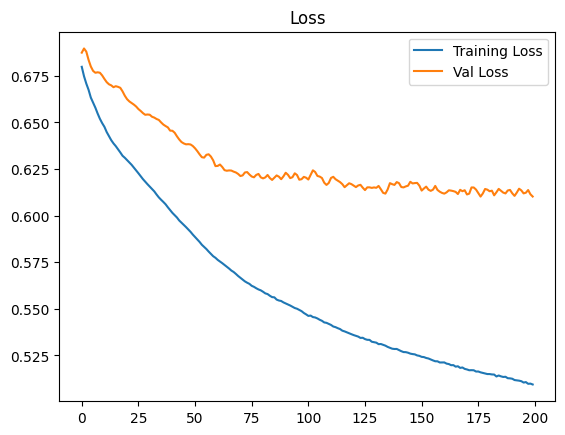

In [12]:
plt.plot(train_losses, label = "Training Loss")
plt.plot(val_losses, label = "Val Loss")
plt.title('Loss')
plt.legend()
plt.show()

In [13]:
#RNNbased, LSTMbased, GRUbased, BI_RNNbased, BI_LSTMbased, BI_GRUbased
train_losses = []
val_losses = []
LSTMmodel = LSTMbased().cuda()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(LSTMmodel.parameters(), lr=1e-3)
epoch(LSTMmodel, optimizer, loss_fn)

100%|██████████| 1/1 [00:00<00:00, 34.48it/s]


Accuracy: 0.5383123181377304
Precision: 0.526702871977555
Recall: 0.5173500801791171
f1_score: 0.48085288243458246


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.5470417070805044
Precision: 0.5441203178206584
Recall: 0.5220511482254697
f1_score: 0.46583096375797817


100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


Accuracy: 0.5441319107662463
Precision: 0.5406269315673289
Recall: 0.517401137635775
f1_score: 0.4497474541011455


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.5402521823472357
Precision: 0.5321577748243782
Recall: 0.5128116395873045
f1_score: 0.43956595932072773


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.553831231813773
Precision: 0.5657624043838486
Recall: 0.5265971528849355
f1_score: 0.4572044645064413


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.5528612997090203
Precision: 0.5613730127680763
Recall: 0.5261054884874891
f1_score: 0.45975968910303405


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.565470417070805
Precision: 0.5821328531412565
Recall: 0.5403656470303471
f1_score: 0.4861836660229427


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.5703200775945684
Precision: 0.585147326601556
Recall: 0.5466892075882727
f1_score: 0.5011135930442762


100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


Accuracy: 0.5809893307468477
Precision: 0.594602289756039
Recall: 0.5596899488669027
f1_score: 0.5260577168638801


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.5984481086323957
Precision: 0.6129755719771532
Recall: 0.5794454025596805
f1_score: 0.555936329588015


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6071774975751697
Precision: 0.6210550576184379
Recall: 0.5893921515234032
f1_score: 0.5703092439776611


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6197866149369544
Precision: 0.6347829531051965
Recall: 0.602962088892923
f1_score: 0.5873642081189251


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6188166828322017
Precision: 0.6289170767577352
Recall: 0.6034367341381501
f1_score: 0.5911937502080944


100%|██████████| 1/1 [00:00<00:00, 39.27it/s]


Accuracy: 0.6275460717749758
Precision: 0.6375736919675755
Recall: 0.6129693503978699
f1_score: 0.6028696615147576


100%|██████████| 1/1 [00:00<00:00, 13.51it/s]


Accuracy: 0.6285160038797284
Precision: 0.637797537619699
Recall: 0.6142892802033222
f1_score: 0.6049124674698362


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6265761396702231
Precision: 0.635084802732583
Recall: 0.6124776860004236
f1_score: 0.6032479027168476


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6294859359844811
Precision: 0.6373432303292723
Recall: 0.6158852984781096
f1_score: 0.6076927061336053


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6333656644034917
Precision: 0.6412558847348421
Recall: 0.6200606638225772
f1_score: 0.6125447387258411


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6362754607177498
Precision: 0.6428353152775595
Recall: 0.6237443647695985
f1_score: 0.61757290225198


100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


Accuracy: 0.6440349175557711
Precision: 0.6492849238103345
Recall: 0.6326472723972043
f1_score: 0.6283195663726636


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6391852570320078
Precision: 0.6419201600133344
Recall: 0.6288085080632961
f1_score: 0.6255126192205844


100%|██████████| 1/1 [00:00<00:00, 43.46it/s]


Accuracy: 0.6420950533462657
Precision: 0.6428125784940486
Recall: 0.6333204744183232
f1_score: 0.6316020858248159


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6382153249272551
Precision: 0.6378946144842956
Recall: 0.630111418716529
f1_score: 0.6288234811522444


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6411251212415131
Precision: 0.6401773344416737
Recall: 0.633933163898218
f1_score: 0.63325834487002


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Accuracy: 0.6430649854510184
Precision: 0.6421069684373568
Recall: 0.6360208465704518
f1_score: 0.635451016564818


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6450048496605237
Precision: 0.6437347931873479
Recall: 0.6385226619466884
f1_score: 0.6382386777620125


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6430649854510184
Precision: 0.6418997668997669
Recall: 0.636296935039787
f1_score: 0.635862471399395


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6440349175557711
Precision: 0.643070886035972
Recall: 0.6370646879065687
f1_score: 0.636545357266701


100%|██████████| 1/1 [00:00<00:00, 45.44it/s]


Accuracy: 0.646944713870029
Precision: 0.6461807147034186
Recall: 0.639920123445584
f1_score: 0.6394135055152004


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6479146459747818
Precision: 0.6472585403665299
Recall: 0.6408259205470334
f1_score: 0.6403007897460837


100%|██████████| 1/1 [00:00<00:00, 13.15it/s]


Accuracy: 0.646944713870029
Precision: 0.6460675265254605
Recall: 0.6400581676802517
f1_score: 0.6396184959552582


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6479146459747818
Precision: 0.6467211443449348
Recall: 0.6415161417203716
f1_score: 0.6413005661511213


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6508244422890398
Precision: 0.6492783376881921
Recall: 0.6451998426673928
f1_score: 0.6452710451869409


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


Accuracy: 0.6479146459747818
Precision: 0.6460608288511396
Recall: 0.6427585398323803
f1_score: 0.6429145950154425


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6498545101842871
Precision: 0.6478743637721669
Recall: 0.645260355208617
f1_score: 0.6455205649712132


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6488845780795345
Precision: 0.647085472666868
Recall: 0.6436643369338295
f1_score: 0.6438150390520618


100%|██████████| 1/1 [00:00<00:00, 13.60it/s]


Accuracy: 0.6566440349175557
Precision: 0.6553755694871695
Recall: 0.6509107137454238
f1_score: 0.65100975329891


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6576139670223085
Precision: 0.6568278777232304
Recall: 0.6512643339082025
f1_score: 0.6511820932543961


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6585838991270611
Precision: 0.6581380331380331
Recall: 0.6518940425403165
f1_score: 0.6516945378602907


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6614936954413191
Precision: 0.6609913200581281
Recall: 0.6550255665486673
f1_score: 0.6549481826280665


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6624636275460718
Precision: 0.6615990595146033
Recall: 0.656483540588787
f1_score: 0.6565754410683655


100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


Accuracy: 0.6605237633365665
Precision: 0.6591362036074879
Recall: 0.655224123324559
f1_score: 0.6554591840631852


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


Accuracy: 0.6605237633365665
Precision: 0.6592156862745098
Recall: 0.6550860790898914
f1_score: 0.6552933039876503


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6624636275460718
Precision: 0.661217239370996
Recall: 0.6570357175274576
f1_score: 0.6572630565362924


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6595538312318138
Precision: 0.6585289227815201
Recall: 0.6536281050497716
f1_score: 0.6537040492629222


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6653734238603298
Precision: 0.664913264425867
Recall: 0.6590628876584672
f1_score: 0.6590873149370161


100%|██████████| 1/1 [00:00<00:00, 12.58it/s]


Accuracy: 0.6644034917555771
Precision: 0.6639647594380347
Recall: 0.6580190463223503
f1_score: 0.6580070560263833


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6585838991270611
Precision: 0.6575723134847171
Recall: 0.6525842637136547
f1_score: 0.6526280323450135


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6634335596508244
Precision: 0.6623534035284321
Recall: 0.6578034703942393
f1_score: 0.6579960442077469


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6653734238603298
Precision: 0.6640919235597713
Recall: 0.6601672415358083
f1_score: 0.6604619195578402


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6644034917555771
Precision: 0.663218792467482
Recall: 0.6589853559650238
f1_score: 0.6592328090849344


100%|██████████| 1/1 [00:00<00:00, 33.32it/s]


Accuracy: 0.6673132880698351
Precision: 0.6662677566752666
Recall: 0.6618407915040392
f1_score: 0.6621051293884732


100%|██████████| 1/1 [00:00<00:00, 13.15it/s]


Accuracy: 0.6692531522793405
Precision: 0.668588087451314
Recall: 0.6633762972376025
f1_score: 0.6635700307654031


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


Accuracy: 0.6702230843840931
Precision: 0.6699009536347038
Recall: 0.6640060058697165
f1_score: 0.6641178950595991


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6682832201745877
Precision: 0.6677573932092005
Recall: 0.6621944116668179
f1_score: 0.662320722625724


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6673132880698351
Precision: 0.6664679292338866
Recall: 0.6615647030347039
f1_score: 0.6617690239561106


100%|██████████| 1/1 [00:00<00:00, 44.43it/s]


Accuracy: 0.6702230843840931
Precision: 0.6691300773919382
Recall: 0.6649723155123899
f1_score: 0.6653032073756655


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6741028128031038
Precision: 0.6730343300110742
Recall: 0.6690096366221899
f1_score: 0.6693973843135159


100%|██████████| 1/1 [00:00<00:00, 13.32it/s]


Accuracy: 0.6721629485935985
Precision: 0.6710382640615199
Recall: 0.6670599981846237
f1_score: 0.6674295116010964


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]

Accuracy: 0.6721629485935985


Precision: 0.6710382640615199
Recall: 0.6670599981846237
f1_score: 0.6674295116010964


100%|██████████| 1/1 [00:00<00:00, 39.19it/s]

Accuracy: 0.6721629485935985
Precision: 0.6709532095901005
Recall: 0.6671980424192914
f1_score: 0.6675843253968253



100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6711930164888458
Precision: 0.6697063149221896
Recall: 0.666706378021845
f1_score: 0.667123189820613


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6721629485935985
Precision: 0.6707309556279808
Recall: 0.6676121751232943
f1_score: 0.66803272441833


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Accuracy: 0.6741028128031038
Precision: 0.672716871229457
Recall: 0.6695618135608605
f1_score: 0.6699970278241387


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6702230843840931
Precision: 0.6688112319679087
Recall: 0.6655244924510605
f1_score: 0.665920752674235


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6653734238603298
Precision: 0.6637521464267289
Recall: 0.6608574627091465
f1_score: 0.661231564861686


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6653734238603298
Precision: 0.6637521464267289
Recall: 0.6608574627091465
f1_score: 0.661231564861686


100%|██████████| 1/1 [00:00<00:00, 40.63it/s]


Accuracy: 0.6682832201745877
Precision: 0.6667006556670566
Recall: 0.6638509424828296
f1_score: 0.6642499657205541


100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


Accuracy: 0.6682832201745877
Precision: 0.6667006556670566
Recall: 0.6638509424828296
f1_score: 0.6642499657205541


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6750727449078564
Precision: 0.6739009460211464
Recall: 0.6701915221929744
f1_score: 0.6706104842732087


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6731328806983511
Precision: 0.6719088140728374
Recall: 0.6682418837554083
f1_score: 0.6686439797017055


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6731328806983511
Precision: 0.6718307358605624
Recall: 0.668379927990076
f1_score: 0.6687943323257426


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6731328806983511
Precision: 0.6718307358605624
Recall: 0.668379927990076
f1_score: 0.6687943323257426


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6711930164888458
Precision: 0.6699166821245286
Recall: 0.6662922453178421
f1_score: 0.6666774751302023


100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


Accuracy: 0.6692531522793405
Precision: 0.6678515465190777
Recall: 0.6644806511149436
f1_score: 0.6648631077836149


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6692531522793405
Precision: 0.6677839025518464
Recall: 0.6646186953496112
f1_score: 0.6650125535371437


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6692531522793405
Precision: 0.6677215920903694
Recall: 0.6647567395842788
f1_score: 0.665159314834304


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6682832201745877
Precision: 0.6667006556670566
Recall: 0.6638509424828296
f1_score: 0.6642499657205541


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6682832201745877
Precision: 0.6668919492998215
Recall: 0.6634368097788267
f1_score: 0.6638043478260869


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6682832201745877
Precision: 0.6668228805060556
Recall: 0.6635748540134943
f1_score: 0.6639555806311424


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]

Accuracy: 0.6682832201745877
Precision: 0.6667591244250284
Recall: 0.6637128982481619
f1_score: 0.6641041176067126



100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6692531522793405
Precision: 0.6677215920903694
Recall: 0.6647567395842788
f1_score: 0.665159314834304


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6682832201745877
Precision: 0.6668228805060556
Recall: 0.6635748540134943
f1_score: 0.6639555806311424


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6692531522793405
Precision: 0.6678515465190777
Recall: 0.6644806511149436
f1_score: 0.6648631077836149


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6731328806983511
Precision: 0.67169103775401
Recall: 0.6686560164594113
f1_score: 0.669087064806922


100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


Accuracy: 0.6711930164888458
Precision: 0.6695929906506157
Recall: 0.6669824664911803
f1_score: 0.6674070119644748


100%|██████████| 1/1 [00:00<00:00, 35.71it/s]


Accuracy: 0.6750727449078564
Precision: 0.6735532269587997
Recall: 0.6708817433663127
f1_score: 0.6713314130032422


100%|██████████| 1/1 [00:00<00:00, 37.72it/s]


Accuracy: 0.6741028128031038
Precision: 0.6726512959428677
Recall: 0.6696998577955282
f1_score: 0.6701403171991407


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6750727449078564
Precision: 0.6735001611492242
Recall: 0.6710197876009802
f1_score: 0.6714677203492447


100%|██████████| 1/1 [00:00<00:00, 35.70it/s]


Accuracy: 0.6741028128031038
Precision: 0.6724872493001495
Recall: 0.670113990499531
f1_score: 0.6705544016616072


100%|██████████| 1/1 [00:00<00:00, 10.71it/s]

Accuracy: 0.6750727449078564
Precision: 0.6735001611492242
Recall: 0.6710197876009802
f1_score: 0.6714677203492447



100%|██████████| 1/1 [00:00<00:00, 35.71it/s]


Accuracy: 0.6721629485935985
Precision: 0.6705575006526312
Recall: 0.6680263078272972
f1_score: 0.6684572059215284


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6731328806983511
Precision: 0.6714767544363958
Recall: 0.6692081933980818
f1_score: 0.6696408281632557


100%|██████████| 1/1 [00:00<00:00, 37.86it/s]


Accuracy: 0.6741028128031038
Precision: 0.6725365089602433
Recall: 0.6699759462648633
f1_score: 0.6704189976024661


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


Accuracy: 0.6731328806983511
Precision: 0.6715731088047077
Recall: 0.6689321049287464
f1_score: 0.6693692124838586


100%|██████████| 1/1 [00:00<00:00, 39.82it/s]


Accuracy: 0.6750727449078564
Precision: 0.6735001611492242
Recall: 0.6710197876009802
f1_score: 0.6714677203492447


100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


Accuracy: 0.6750727449078564
Precision: 0.6735001611492242
Recall: 0.6710197876009802
f1_score: 0.6714677203492447


100%|██████████| 1/1 [00:00<00:00, 35.07it/s]


Accuracy: 0.6750727449078564
Precision: 0.6736117520381479
Recall: 0.6707436991316451
f1_score: 0.6711924883165448


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


Accuracy: 0.6750727449078564
Precision: 0.6736757605858301
Recall: 0.6706056548969774
f1_score: 0.6710509397932312


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6731328806983511
Precision: 0.6715222462667096
Recall: 0.6690701491634141
f1_score: 0.6695063336050612


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6770126091173618
Precision: 0.6756604834176503
Recall: 0.6725552933345436
f1_score: 0.6730148147795403


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


Accuracy: 0.6799224054316197
Precision: 0.678837078174361
Recall: 0.6751346404042238
f1_score: 0.6756006864988559


100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


Accuracy: 0.6789524733268671
Precision: 0.6777195281782438
Recall: 0.6743668875374421
f1_score: 0.6748362323190457


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6731328806983511
Precision: 0.6715222462667096
Recall: 0.6690701491634141
f1_score: 0.6695063336050612


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


Accuracy: 0.6770126091173618
Precision: 0.6755333451128918
Recall: 0.6728313818038789
f1_score: 0.6732936135226257


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6789524733268671
Precision: 0.6775765266882019
Recall: 0.6746429760067774
f1_score: 0.6751185481575412


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6770126091173618
Precision: 0.6755333451128918
Recall: 0.6728313818038789
f1_score: 0.6732936135226257


100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


Accuracy: 0.6760426770126091
Precision: 0.674572427841193
Recall: 0.671787540467762
f1_score: 0.67224358486256


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6741028128031038
Precision: 0.6725365089602433
Recall: 0.6699759462648633
f1_score: 0.6704189976024661


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6770126091173618
Precision: 0.6755333451128918
Recall: 0.6728313818038789
f1_score: 0.6732936135226257


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6750727449078564
Precision: 0.6735001611492242
Recall: 0.6710197876009802
f1_score: 0.6714677203492447


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6760426770126091
Precision: 0.6744640871265866
Recall: 0.6720636289370971
f1_score: 0.6725153873660024


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Accuracy: 0.6750727449078564
Precision: 0.6735001611492242
Recall: 0.6710197876009802
f1_score: 0.6714677203492447


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]

Accuracy: 0.6741028128031038
Precision: 0.6725911833660018
Recall: 0.6698379020301958
f1_score: 0.6702809715982639



100%|██████████| 1/1 [00:00<00:00, 41.66it/s]

Accuracy: 0.6731328806983511


Precision: 0.6715731088047077
Recall: 0.6689321049287464
f1_score: 0.6693692124838586


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6721629485935985
Precision: 0.6705104114737125
Recall: 0.6681643520619649
f1_score: 0.6685934159572121


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6741028128031038
Precision: 0.6724872493001495
Recall: 0.670113990499531
f1_score: 0.6705544016616072


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6779825412221144
Precision: 0.6767646378153205
Recall: 0.6733230462013252
f1_score: 0.6737814408466061


100%|██████████| 1/1 [00:00<00:00, 12.58it/s]


Accuracy: 0.6750727449078564
Precision: 0.6736117520381479
Recall: 0.6707436991316451
f1_score: 0.6711924883165448


100%|██████████| 1/1 [00:00<00:00, 40.63it/s]


Accuracy: 0.6731328806983511
Precision: 0.6715731088047077
Recall: 0.6689321049287464
f1_score: 0.6693692124838586


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6750727449078564
Precision: 0.6736117520381479
Recall: 0.6707436991316451
f1_score: 0.6711924883165448


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6750727449078564
Precision: 0.6736117520381479
Recall: 0.6707436991316451
f1_score: 0.6711924883165448


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6702230843840931
Precision: 0.6685335736472754
Recall: 0.6662147136243987
f1_score: 0.6666324302528169


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6750727449078564
Precision: 0.6736117520381479
Recall: 0.6707436991316451
f1_score: 0.6711924883165448


100%|██████████| 1/1 [00:00<00:00, 13.42it/s]

Accuracy: 0.6770126091173618


Precision: 0.6756604834176503
Recall: 0.6725552933345436
f1_score: 0.6730148147795403


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6731328806983511
Precision: 0.6715222462667096
Recall: 0.6690701491634141
f1_score: 0.6695063336050612


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6692531522793405
Precision: 0.6674892030139672
Recall: 0.665446960757617
f1_score: 0.6658530905911257


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6760426770126091
Precision: 0.6746348427014714
Recall: 0.6716494962330943
f1_score: 0.672103767692003


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6721629485935985
Precision: 0.6705575006526312
Recall: 0.6680263078272972
f1_score: 0.6684572059215284


100%|██████████| 1/1 [00:00<00:00, 12.57it/s]


Accuracy: 0.6682832201745877
Precision: 0.6664595917119045
Recall: 0.6646792078908353
f1_score: 0.6650689615866864


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6721629485935985
Precision: 0.6705575006526312
Recall: 0.6680263078272972
f1_score: 0.6684572059215284


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6731328806983511
Precision: 0.67169103775401
Recall: 0.6686560164594113
f1_score: 0.669087064806922


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6750727449078564
Precision: 0.6735001611492242
Recall: 0.6710197876009802
f1_score: 0.6714677203492447


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6721629485935985
Precision: 0.6705104114737125
Recall: 0.6681643520619649
f1_score: 0.6685934159572121


100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


Accuracy: 0.6779825412221144
Precision: 0.6767646378153205
Recall: 0.6733230462013252
f1_score: 0.6737814408466061


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


Accuracy: 0.6789524733268671
Precision: 0.6775134632669837
Recall: 0.674781020241445
f1_score: 0.6752558140420094


100%|██████████| 1/1 [00:00<00:00, 33.33it/s]


Accuracy: 0.6731328806983511
Precision: 0.6714017976668579
Recall: 0.6694842818674169
f1_score: 0.669901962554047


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6731328806983511
Precision: 0.6715731088047077
Recall: 0.6689321049287464
f1_score: 0.6693692124838586


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6741028128031038
Precision: 0.6725365089602433
Recall: 0.6699759462648633
f1_score: 0.6704189976024661


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6731328806983511
Precision: 0.6715222462667096
Recall: 0.6690701491634141
f1_score: 0.6695063336050612


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Accuracy: 0.6770126091173618
Precision: 0.6755333451128918
Recall: 0.6728313818038789
f1_score: 0.6732936135226257


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6760426770126091
Precision: 0.6745155172678552
Recall: 0.6719255847024296
f1_score: 0.6723807892834037


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6750727449078564
Precision: 0.6735001611492242
Recall: 0.6710197876009802
f1_score: 0.6714677203492447


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6750727449078564
Precision: 0.6735001611492242
Recall: 0.6710197876009802
f1_score: 0.6714677203492447


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6770126091173618
Precision: 0.6755333451128918
Recall: 0.6728313818038789
f1_score: 0.6732936135226257


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6770126091173618
Precision: 0.6756604834176503
Recall: 0.6725552933345436
f1_score: 0.6730148147795403


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Accuracy: 0.6779825412221144
Precision: 0.6766183894600751
Recall: 0.6735991346706605
f1_score: 0.6740672181848653


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6799224054316197
Precision: 0.6784177627794609
Recall: 0.6759629058122296
f1_score: 0.6764373587747928


100%|██████████| 1/1 [00:00<00:00, 41.50it/s]


Accuracy: 0.6857419980601358
Precision: 0.6846323648383146
Recall: 0.6812596441862575
f1_score: 0.6817828482589908


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6828322017458778
Precision: 0.6816146519131111
Recall: 0.6784042086472422
f1_score: 0.6789064397384674


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6799224054316197
Precision: 0.6784177627794609
Recall: 0.6759629058122296
f1_score: 0.6764373587747928


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Accuracy: 0.6818622696411252
Precision: 0.680660533635362
Recall: 0.6773603673111253
f1_score: 0.6778542414473734


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6838021338506305
Precision: 0.6825690297358862
Recall: 0.6794480499833591
f1_score: 0.679957569663452


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


Accuracy: 0.6799224054316197
Precision: 0.6782503418196262
Recall: 0.6765150827509001
f1_score: 0.6769436742755137


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6847720659553831
Precision: 0.6836809035540822
Recall: 0.6802158028501406
f1_score: 0.6807304395881868


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6828322017458778
Precision: 0.6814118206792823
Recall: 0.6788183413512451
f1_score: 0.6793132673259793


100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


Accuracy: 0.6828322017458778
Precision: 0.6812602792120864
Recall: 0.679232474055248
f1_score: 0.6796971565435411


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6847720659553831
Precision: 0.6835993747449314
Recall: 0.6803538470848083
f1_score: 0.6808703147247765


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6838021338506305
Precision: 0.6824974057419577
Recall: 0.6795860942180267
f1_score: 0.6800940379197442


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6808923375363725
Precision: 0.6794339057967678
Recall: 0.6768687029136788
f1_score: 0.6773518805817956


100%|██████████| 1/1 [00:00<00:00, 44.42it/s]


Accuracy: 0.6770126091173618
Precision: 0.6756604834176503
Recall: 0.6725552933345436
f1_score: 0.6730148147795403


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6828322017458778
Precision: 0.6816937784288026
Recall: 0.6782661644125745
f1_score: 0.6787657038318065


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Accuracy: 0.6828322017458778
Precision: 0.6812602792120864
Recall: 0.679232474055248
f1_score: 0.6796971565435411


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6799224054316197
Precision: 0.6786746180338857
Recall: 0.675410728873559
f1_score: 0.6758899380415646


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6818622696411252
Precision: 0.6805161612667666
Recall: 0.6776364557804605
f1_score: 0.6781314246554482


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6876818622696411
Precision: 0.6862665103735711
Recall: 0.683899503797162
f1_score: 0.684408557174581


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6847720659553831
Precision: 0.6831908080761765
Recall: 0.6813201567274818
f1_score: 0.681778337469289


100%|██████████| 1/1 [00:00<00:00, 43.46it/s]


Accuracy: 0.6838021338506305
Precision: 0.6825690297358862
Recall: 0.6794480499833591
f1_score: 0.679957569663452


100%|██████████| 1/1 [00:00<00:00, 13.70it/s]


Accuracy: 0.6867119301648884
Precision: 0.6850915331807781
Recall: 0.6835458836343833
f1_score: 0.6839719286924255


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


Accuracy: 0.6847720659553831
Precision: 0.6833897355617968
Recall: 0.6807679797888113
f1_score: 0.6812746540701629


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6818622696411252
Precision: 0.6804525421906912
Recall: 0.6777745000151282
f1_score: 0.6782661643262169


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6838021338506305
Precision: 0.6822253230369295
Recall: 0.6802763153913649
f1_score: 0.6807382499335081


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6867119301648884
Precision: 0.6854339358833517
Recall: 0.6825795739917098
f1_score: 0.6831046161195439


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Accuracy: 0.6867119301648884
Precision: 0.6854339358833517
Recall: 0.6825795739917098
f1_score: 0.6831046161195439


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6857419980601358
Precision: 0.684095258426795
Recall: 0.682640086532934
f1_score: 0.6830509632463452


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6828322017458778
Precision: 0.6814736995751677
Recall: 0.6786802971165775
f1_score: 0.6791802150807766


100%|██████████| 1/1 [00:00<00:00, 42.73it/s]


Accuracy: 0.6847720659553831
Precision: 0.6833314169637039
Recall: 0.6809060240234789
f1_score: 0.6814043595046233


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6828322017458778
Precision: 0.6812602792120864
Recall: 0.679232474055248
f1_score: 0.6796971565435411


100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


Accuracy: 0.6857419980601358
Precision: 0.6844786502171489
Recall: 0.6815357326555929
f1_score: 0.6820566511840402


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6857419980601358
Precision: 0.6841960394525575
Recall: 0.682225953828931
f1_score: 0.6826969109768608


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6818622696411252
Precision: 0.6805161612667666
Recall: 0.6776364557804605
f1_score: 0.6781314246554482


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6847720659553831
Precision: 0.6836809035540822
Recall: 0.6802158028501406
f1_score: 0.6807304395881868


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6779825412221144
Precision: 0.6763502705515885
Recall: 0.6742893558439986
f1_score: 0.6747362099373593


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


Accuracy: 0.6808923375363725
Precision: 0.6796299290812908
Recall: 0.6764545702096759
f1_score: 0.6769425647521583


100%|██████████| 1/1 [00:00<00:00, 12.82it/s]


Accuracy: 0.6857419980601358
Precision: 0.6846323648383146
Recall: 0.6812596441862575
f1_score: 0.6817828482589908


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6818622696411252
Precision: 0.6802546066213013
Recall: 0.6783266769537987
f1_score: 0.6787795888901553


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6818622696411252
Precision: 0.6805161612667666
Recall: 0.6776364557804605
f1_score: 0.6781314246554482


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6838021338506305
Precision: 0.6824974057419577
Recall: 0.6795860942180267
f1_score: 0.6800940379197442


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6818622696411252
Precision: 0.6802546066213013
Recall: 0.6783266769537987
f1_score: 0.6787795888901553


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6828322017458778
Precision: 0.6813556398758193
Recall: 0.6789563855859126
f1_score: 0.6794437709477288


100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


Accuracy: 0.6838021338506305
Precision: 0.6826464492368383
Recall: 0.6793100057486914
f1_score: 0.679818544853182


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6828322017458778
Precision: 0.681159420289855
Recall: 0.6796466067592508
f1_score: 0.6800582683666351


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6818622696411252
Precision: 0.6804525421906912
Recall: 0.6777745000151282
f1_score: 0.6782661643262169


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6857419980601358
Precision: 0.6847180436627324
Recall: 0.6811215999515899
f1_score: 0.6816421290189769


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6838021338506305
Precision: 0.6821300863837023
Recall: 0.6806904480953677
f1_score: 0.6810944877108287


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Accuracy: 0.6838021338506305
Precision: 0.6823170451411236
Recall: 0.6800002269220295
f1_score: 0.6804881665804764


100%|██████████| 1/1 [00:00<00:00, 44.42it/s]


Accuracy: 0.6847720659553831
Precision: 0.6837683038850164
Recall: 0.680077758615473
f1_score: 0.6805880059521257


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]

Accuracy: 0.6857419980601358
Precision: 0.6840730076024193
Recall: 0.6827781307676015
f1_score: 0.6831639969951968



100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6867119301648884
Precision: 0.6853676504443114
Recall: 0.6827176182263774
f1_score: 0.6832360408143465


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]

Accuracy: 0.6857419980601358
Precision: 0.6846323648383146
Recall: 0.6812596441862575
f1_score: 0.6817828482589908


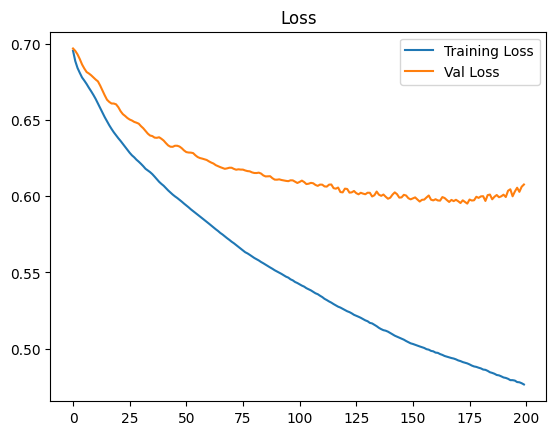

In [14]:
plt.plot(train_losses, label = "Training Loss")
plt.plot(val_losses, label = "Val Loss")
plt.title('Loss')
plt.legend()
plt.show()

In [15]:
#RNNbased, LSTMbased, GRUbased, BI_RNNbased, BI_LSTMbased, BI_GRUbased
train_losses = []
val_losses = []
GRUmodel = GRUbased().cuda()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(GRUmodel.parameters(), lr=1e-3)
epoch(GRUmodel, optimizer, loss_fn)

100%|██████████| 1/1 [00:00<00:00, 12.58it/s]


Accuracy: 0.5383123181377304
Precision: 0.5582483877678386
Recall: 0.5042358778856918
f1_score: 0.3699144403701764


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.542192046556741
Precision: 0.5591728645481181
Recall: 0.5099297298115034
f1_score: 0.396172286800544


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.550921435499515
Precision: 0.5722262201547199
Recall: 0.5212569211219025
f1_score: 0.43311351552916


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.5383123181377304
Precision: 0.5266674635429118
Recall: 0.5126565762004175
f1_score: 0.45108048856874405


100%|██████████| 1/1 [00:00<00:00, 41.50it/s]


Accuracy: 0.5489815712900097
Precision: 0.5488264123762996
Recall: 0.523586653959033
f1_score: 0.4652352433973566


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Accuracy: 0.5460717749757517
Precision: 0.5480059304662779
Recall: 0.5182464221960001
f1_score: 0.4432891202614017


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.5499515033947624
Precision: 0.5772168489559795
Recall: 0.5193848143777798
f1_score: 0.4234058760570442


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.5441319107662463
Precision: 0.5634139753829532
Recall: 0.5124315451877401
f1_score: 0.4046759054498993


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.5441319107662463
Precision: 0.5687056737588652
Recall: 0.5120174124837372
f1_score: 0.4002371474968314


100%|██████████| 1/1 [00:00<00:00, 40.66it/s]


Accuracy: 0.5480116391852571
Precision: 0.5833043947987807
Recall: 0.5163308220628725
f1_score: 0.4097424934886235


100%|██████████| 1/1 [00:00<00:00, 13.15it/s]


Accuracy: 0.5460717749757517
Precision: 0.5606073943661971
Recall: 0.515623581737315
f1_score: 0.41978354978354976


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]

Accuracy: 0.5645004849660524
Precision: 0.601247388083328
Recall: 0.5362848325315421
f1_score: 0.46201048042851445



100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.5761396702230844
Precision: 0.6035054023445869
Recall: 0.5511576805542949
f1_score: 0.49925034315278216


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.5790494665373423
Precision: 0.5956807871701488
Recall: 0.5566359565519954
f1_score: 0.5179710257338366


100%|██████████| 1/1 [00:00<00:00, 43.29it/s]


Accuracy: 0.5790494665373423
Precision: 0.5924783016226612
Recall: 0.5574642219600012
f1_score: 0.5224284262745801


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.5780795344325897
Precision: 0.5901985559566787
Recall: 0.5566964690932196
f1_score: 0.5224091828291573


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]

Accuracy: 0.5819592628516004
Precision: 0.6003149456003054
Recall: 0.5596294363256785
f1_score: 0.5216807229239886



100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.5897187196896218
Precision: 0.6149089426474585
Recall: 0.567151901606608
f1_score: 0.5290666597556749


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.5906886517943744
Precision: 0.6126170131203086
Recall: 0.5688859641160631
f1_score: 0.5342133436108256


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.5926285160038798
Precision: 0.611902793362074
Recall: 0.571663867961635
f1_score: 0.5405876811040664


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.5945683802133851
Precision: 0.6069790441569549
Recall: 0.5756841699192157
f1_score: 0.5522384027795093


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6032977691561591
Precision: 0.6140778402880152
Recall: 0.5860450515869414
f1_score: 0.5681841222702952


100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


Accuracy: 0.6100872938894277
Precision: 0.6185053380782918
Recall: 0.5944562948171008
f1_score: 0.581148435605142


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6159068865179438
Precision: 0.6236646410832709
Recall: 0.6011334755378053
f1_score: 0.590034943969153


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6207565470417071
Precision: 0.6283948928408573
Recall: 0.6064907264530575
f1_score: 0.5966599863726003


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6217264791464597
Precision: 0.6284147965519102
Recall: 0.6079487004931772
f1_score: 0.5990870803321449


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6256062075654704
Precision: 0.6327219428233333
Recall: 0.6119860216029772
f1_score: 0.6035847763548997


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Accuracy: 0.6333656644034917
Precision: 0.6412558847348421
Recall: 0.6200606638225772
f1_score: 0.6125447387258411


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6382153249272551
Precision: 0.646096306685367
Recall: 0.6252798705031618
f1_score: 0.6185666605501858


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6372453928225025
Precision: 0.6451325009499067
Recall: 0.6242360291670449
f1_score: 0.6173660561893195


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6382153249272551
Precision: 0.6457520218002812
Recall: 0.6254179147378294
f1_score: 0.6189189376665409


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6391852570320078
Precision: 0.6463766594951986
Recall: 0.626599800308614
f1_score: 0.6204607528797055


100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


Accuracy: 0.6430649854510184
Precision: 0.649235912129895
Recall: 0.6311892983570845
f1_score: 0.6261990147783252


100%|██████████| 1/1 [00:00<00:00, 43.46it/s]


Accuracy: 0.6411251212415131
Precision: 0.6461349259126639
Recall: 0.6296537926235212
f1_score: 0.6251248044402864


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6450048496605237
Precision: 0.6499487253373111
Recall: 0.6338291579679889
f1_score: 0.6297916176124323


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]

Accuracy: 0.6450048496605237
Precision: 0.6508307750194546
Recall: 0.633415025263986
f1_score: 0.6288653101690116



100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6508244422890398
Precision: 0.6568086191508351
Recall: 0.6395400290460198
f1_score: 0.6355602686461647


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6488845780795345
Precision: 0.6540245912029408
Recall: 0.6378664790777888
f1_score: 0.634136251705695


100%|██████████| 1/1 [00:00<00:00, 13.42it/s]


Accuracy: 0.6556741028128031
Precision: 0.6597719707471756
Recall: 0.6455875011346102
f1_score: 0.6430351352010337


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6595538312318138
Precision: 0.6627483769427504
Recall: 0.6501769991830807
f1_score: 0.6483536665354848


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6576139670223085
Precision: 0.6595201633486473
Recall: 0.6489175819188526
f1_score: 0.6475759791223848


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


Accuracy: 0.6576139670223085
Precision: 0.6593156277791252
Recall: 0.6490556261535203
f1_score: 0.6478119795582832


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6605237633365665
Precision: 0.6627608919605124
Recall: 0.6517730174578682
f1_score: 0.6504529533020256


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6634335596508244
Precision: 0.6669740638730408
Recall: 0.6540762760582131
f1_score: 0.6523610321590121


100%|██████████| 1/1 [00:00<00:00, 12.58it/s]


Accuracy: 0.6634335596508244
Precision: 0.666723228523531
Recall: 0.6542143202928807
f1_score: 0.6526081311896931


100%|██████████| 1/1 [00:00<00:00, 32.77it/s]


Accuracy: 0.6634335596508244
Precision: 0.6669740638730408
Recall: 0.6540762760582131
f1_score: 0.6523610321590121


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6624636275460718
Precision: 0.6655476598872825
Recall: 0.6533085231914315
f1_score: 0.6517297612114152


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6663433559650824
Precision: 0.6697582291921915
Recall: 0.6572078000665638
f1_score: 0.6557328674043874


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6634335596508244
Precision: 0.6653550770819384
Recall: 0.6550425857008866
f1_score: 0.6540271802147068


100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


Accuracy: 0.6653734238603298
Precision: 0.6670201229063742
Recall: 0.657268312607788
f1_score: 0.6564677589928578


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6605237633365665
Precision: 0.6619396083792368
Recall: 0.6523251943965387
f1_score: 0.6513769090459408


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6663433559650824
Precision: 0.6685826771653544
Recall: 0.6578980212399019
f1_score: 0.6569051580698835


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6682832201745877
Precision: 0.6702303888062402
Recall: 0.6601237481468034
f1_score: 0.6593454368391765


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6702230843840931
Precision: 0.6718861366712314
Recall: 0.6623494750537049
f1_score: 0.6617689059738014


100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


Accuracy: 0.6721629485935985
Precision: 0.6733600031844598
Recall: 0.6647132461952739
f1_score: 0.6643802633505149


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6721629485935985
Precision: 0.6729977633958313
Recall: 0.6649893346646092
f1_score: 0.6647805977959736


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6731328806983511
Precision: 0.6737615578704252
Recall: 0.6661712202353938
f1_score: 0.6660643695438849


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6702230843840931
Precision: 0.6716871803069053
Recall: 0.6624875192883726
f1_score: 0.6619802514849957


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6682832201745877
Precision: 0.6704441059858814
Recall: 0.6599857039121357
f1_score: 0.6591241299303945


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6653734238603298
Precision: 0.6678739557759465
Recall: 0.6567161356691174
f1_score: 0.6555629257711693


100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


Accuracy: 0.6673132880698351
Precision: 0.6690906534923886
Recall: 0.6592179510453542
f1_score: 0.6584592502450732


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6741028128031038
Precision: 0.6752238794110402
Recall: 0.6668009288675079
f1_score: 0.6665665642541986


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6721629485935985
Precision: 0.6726600654328208
Recall: 0.6652654231339445
f1_score: 0.665169683692686


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6760426770126091
Precision: 0.6762513856241008
Recall: 0.6695788327130798
f1_score: 0.6696882146200716


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6731328806983511
Precision: 0.6739322503961965
Recall: 0.6660331760007261
f1_score: 0.6658704033343046


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6721629485935985
Precision: 0.6733600031844598
Recall: 0.6647132461952739
f1_score: 0.6643802633505149


100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


Accuracy: 0.6711930164888458
Precision: 0.6726190476190477
Recall: 0.6635313606244895
f1_score: 0.6630787160882277


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6741028128031038
Precision: 0.6752238794110402
Recall: 0.6668009288675079
f1_score: 0.6665665642541986


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6721629485935985
Precision: 0.6726600654328208
Recall: 0.6652654231339445
f1_score: 0.665169683692686


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6692531522793405
Precision: 0.669526821103163
Recall: 0.6624099875949291
f1_score: 0.6622941875420847


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


Accuracy: 0.6711930164888458
Precision: 0.6718898573692551
Recall: 0.66408353756316
f1_score: 0.6638874383689295


100%|██████████| 1/1 [00:00<00:00, 13.11it/s]


Accuracy: 0.6760426770126091
Precision: 0.677662383242799
Recall: 0.6684744788357386
f1_score: 0.6681501040783284


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6731328806983511
Precision: 0.6742921339378032
Recall: 0.6657570875313908
f1_score: 0.6654740642676615


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6702230843840931
Precision: 0.6703167328167328
Recall: 0.6635918731657136
f1_score: 0.6635685877059627


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6702230843840931
Precision: 0.6697739007979971
Recall: 0.6641440501043842
f1_score: 0.6642954552419478


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6721629485935985
Precision: 0.6717904083867939
Recall: 0.6660936885419504
f1_score: 0.6662701878581718


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Accuracy: 0.6721629485935985
Precision: 0.6712250048534265
Recall: 0.6667839097152886
f1_score: 0.6671118192795024


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6741028128031038
Precision: 0.6731276269057183
Recall: 0.6688715923875224
f1_score: 0.6692408167006576


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6750727449078564
Precision: 0.6750199978041627
Recall: 0.6688110798462982
f1_score: 0.6689688420402911


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6770126091173618
Precision: 0.6780170364500793
Recall: 0.6699324528758586
f1_score: 0.6698363332650548


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6770126091173618
Precision: 0.6775014778325124
Recall: 0.6703465855798614
f1_score: 0.6704030643837392


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6799224054316197
Precision: 0.6799995298432027
Recall: 0.6737541980575474
f1_score: 0.6739967804990228


100%|██████████| 1/1 [00:00<00:00, 13.15it/s]


Accuracy: 0.6808923375363725
Precision: 0.6810840378311401
Recall: 0.6746599951589967
f1_score: 0.6748977583022558


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6760426770126091
Precision: 0.675448775359215
Recall: 0.6704070981210857
f1_score: 0.6707267163893671


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6770126091173618
Precision: 0.6763943688277729
Recall: 0.6714509394572026
f1_score: 0.6717944747008062


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6760426770126091
Precision: 0.6752281110463987
Recall: 0.6706831865904208
f1_score: 0.6710513243767864


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6799224054316197
Precision: 0.6793443604578823
Recall: 0.6744444192308856
f1_score: 0.6748317914213624


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6760426770126091
Precision: 0.6751264016626084
Recall: 0.6708212308250885
f1_score: 0.6712096213631538


100%|██████████| 1/1 [00:00<00:00, 13.30it/s]


Accuracy: 0.6779825412221144
Precision: 0.677339958939903
Recall: 0.6724947807933195
f1_score: 0.6728610750057344


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6808923375363725
Precision: 0.6805295768061725
Recall: 0.6752121720976673
f1_score: 0.6755743699170857


100%|██████████| 1/1 [00:00<00:00, 44.42it/s]


Accuracy: 0.6818622696411252
Precision: 0.6818729463307776
Recall: 0.6758418807297812
f1_score: 0.6761438509392909


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6838021338506305
Precision: 0.6838894539195743
Recall: 0.6777915191673474
f1_score: 0.6781185835555147


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6808923375363725
Precision: 0.6805295768061725
Recall: 0.6752121720976673
f1_score: 0.6755743699170857


100%|██████████| 1/1 [00:00<00:00, 13.42it/s]


Accuracy: 0.6818622696411252
Precision: 0.6817327896640342
Recall: 0.6759799249644489
f1_score: 0.6763124846851263


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6799224054316197
Precision: 0.6795884224811644
Recall: 0.6741683307615504
f1_score: 0.6745057745735081


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6808923375363725
Precision: 0.6800712171231071
Recall: 0.6757643490363378
f1_score: 0.6762086131435635


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6799224054316197
Precision: 0.6791239511763885
Recall: 0.6747205077002209
f1_score: 0.675147230688146


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6857419980601358
Precision: 0.6854853782952377
Recall: 0.6801552903089165
f1_score: 0.6805851979345956


100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


Accuracy: 0.6828322017458778
Precision: 0.6821770845458426
Recall: 0.6775759432392363
f1_score: 0.6780232741372477


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6818622696411252
Precision: 0.6813487619758616
Recall: 0.6763940576684517
f1_score: 0.6768025078369906


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6799224054316197
Precision: 0.6793443604578823
Recall: 0.6744444192308856
f1_score: 0.6748317914213624


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6789524733268671
Precision: 0.67828556774735
Recall: 0.6735386221294364
f1_score: 0.6739265242786723


100%|██████████| 1/1 [00:00<00:00, 44.43it/s]


Accuracy: 0.6770126091173618
Precision: 0.6763943688277729
Recall: 0.6714509394572026
f1_score: 0.6717944747008062


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6770126091173618
Precision: 0.6763943688277729
Recall: 0.6714509394572026
f1_score: 0.6717944747008062


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Accuracy: 0.6779825412221144
Precision: 0.6774560959464195
Recall: 0.6723567365586518
f1_score: 0.6726984126984127


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6789524733268671
Precision: 0.6787797060662915
Recall: 0.6729864451907658
f1_score: 0.6732671750609163


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6770126091173618
Precision: 0.676176618942304
Recall: 0.6717270279265377
f1_score: 0.6721154443049036


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6789524733268671
Precision: 0.6778852099177641
Recall: 0.6740907990681069
f1_score: 0.6745434934162153


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6828322017458778
Precision: 0.6817787092142742
Recall: 0.6781281201779068
f1_score: 0.6786223936810618


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6828322017458778
Precision: 0.681869473814382
Recall: 0.6779900759432392
f1_score: 0.6784765025592217


100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


Accuracy: 0.6779825412221144
Precision: 0.6771251764194984
Recall: 0.6727708692626546
f1_score: 0.6731784260256499


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6760426770126091
Precision: 0.6752281110463987
Recall: 0.6706831865904208
f1_score: 0.6710513243767864


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6750727449078564
Precision: 0.6742796307233223
Recall: 0.6696393452543039
f1_score: 0.6699860593152724


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6760426770126091
Precision: 0.6752281110463987
Recall: 0.6706831865904208
f1_score: 0.6710513243767864


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6818622696411252
Precision: 0.6812327703358572
Recall: 0.6765321019031194
f1_score: 0.6769605820227124


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Accuracy: 0.6779825412221144
Precision: 0.6772296641428849
Recall: 0.672632825027987
f1_score: 0.6730210769254283


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6760426770126091
Precision: 0.675448775359215
Recall: 0.6704070981210857
f1_score: 0.6707267163893671


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6770126091173618
Precision: 0.676176618942304
Recall: 0.6717270279265377
f1_score: 0.6721154443049036


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6779825412221144
Precision: 0.6769334880123743
Recall: 0.67304695773199
f1_score: 0.6734851953601955


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6770126091173618
Precision: 0.676176618942304
Recall: 0.6717270279265377
f1_score: 0.6721154443049036


100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


Accuracy: 0.6750727449078564
Precision: 0.6742796307233223
Recall: 0.6696393452543039
f1_score: 0.6699860593152724


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6760426770126091
Precision: 0.6749400618716164
Recall: 0.6710973192944237
f1_score: 0.6715182387057387


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6741028128031038
Precision: 0.6732265579499126
Recall: 0.6687335481528547
f1_score: 0.6690815718281444


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6750727449078564
Precision: 0.6741764637411245
Recall: 0.6697773894889716
f1_score: 0.6701461676941223


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6770126091173618
Precision: 0.676176618942304
Recall: 0.6717270279265377
f1_score: 0.6721154443049036


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6828322017458778
Precision: 0.6832626369741959
Recall: 0.6764715893618952
f1_score: 0.6766993000555238


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Accuracy: 0.6721629485935985
Precision: 0.6709532095901005
Recall: 0.6671980424192914
f1_score: 0.6675843253968253


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6721629485935985
Precision: 0.6711288521488282
Recall: 0.6669219539499561
f1_score: 0.6672720120381616


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]

Accuracy: 0.6750727449078564
Precision: 0.6740789820368562
Recall: 0.6699154337236393
f1_score: 0.6703036030489173



100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6731328806983511
Precision: 0.6719924157412065
Recall: 0.6681038395207406
f1_score: 0.6684909601107552


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6741028128031038
Precision: 0.6736792976042618
Recall: 0.6681813712141842
f1_score: 0.6684176672384219


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6750727449078564
Precision: 0.6740789820368562
Recall: 0.6699154337236393
f1_score: 0.6703036030489173


100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


Accuracy: 0.6682832201745877
Precision: 0.6667006556670566
Recall: 0.6638509424828296
f1_score: 0.6642499657205541


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6770126091173618
Precision: 0.6769000696842287
Recall: 0.670898762518532
f1_score: 0.6711204051663111


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6770126091173618
Precision: 0.6769000696842287
Recall: 0.670898762518532
f1_score: 0.6711204051663111


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6711930164888458
Precision: 0.6696469773880942
Recall: 0.6668444222565126
f1_score: 0.6672664284755483


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6711930164888458
Precision: 0.6699976782881244
Recall: 0.6661542010831745
f1_score: 0.6665235474111157


100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


Accuracy: 0.6702230843840931
Precision: 0.6694268135976014
Recall: 0.6645581828083871
f1_score: 0.6648116274622299


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6692531522793405
Precision: 0.6677215920903694
Recall: 0.6647567395842788
f1_score: 0.665159314834304


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6682832201745877
Precision: 0.6670461321624113
Recall: 0.6631607213094914
f1_score: 0.6634937661762573


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6770126091173618
Precision: 0.6767647748592871
Recall: 0.6710368067531995
f1_score: 0.6712929585960277


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6770126091173618
Precision: 0.6762825992353362
Recall: 0.6715889836918701
f1_score: 0.6719562917969724


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Accuracy: 0.6702230843840931
Precision: 0.6686286944156195
Recall: 0.6659386251550634
f1_score: 0.6663557450696718


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6702230843840931
Precision: 0.669536868048731
Recall: 0.6644201385737194
f1_score: 0.6646423131969477


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6711930164888458
Precision: 0.6707199812382739
Recall: 0.6651878914405011
f1_score: 0.6653703092013614


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6702230843840931
Precision: 0.6688112319679087
Recall: 0.6655244924510605
f1_score: 0.665920752674235


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6692531522793405
Precision: 0.6677215920903694
Recall: 0.6647567395842788
f1_score: 0.665159314834304


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6741028128031038
Precision: 0.6732265579499126
Recall: 0.6687335481528547
f1_score: 0.6690815718281444


100%|██████████| 1/1 [00:00<00:00, 13.42it/s]

Accuracy: 0.6721629485935985
Precision: 0.6712250048534265
Recall: 0.6667839097152886
f1_score: 0.6671118192795024



100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6731328806983511
Precision: 0.6718307358605624
Recall: 0.668379927990076
f1_score: 0.6687943323257426


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6741028128031038
Precision: 0.6730343300110742
Recall: 0.6690096366221899
f1_score: 0.6693973843135159


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6770126091173618
Precision: 0.6762825992353362
Recall: 0.6715889836918701
f1_score: 0.6719562917969724


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6741028128031038
Precision: 0.6727879348916146
Recall: 0.6694237693261929
f1_score: 0.6698510967604205


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6721629485935985
Precision: 0.6707995834297616
Recall: 0.6674741308886267
f1_score: 0.6678859247173279


100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


Accuracy: 0.6731328806983511
Precision: 0.6719924157412065
Recall: 0.6681038395207406
f1_score: 0.6684909601107552


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6760426770126091
Precision: 0.6748553685495146
Recall: 0.6712353635290913
f1_score: 0.6716685736079329


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6770126091173618
Precision: 0.6758099252020471
Recall: 0.6722792048652083
f1_score: 0.6727255568678702


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6770126091173618
Precision: 0.6758099252020471
Recall: 0.6722792048652083
f1_score: 0.6727255568678702


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6731328806983511
Precision: 0.6719088140728374
Recall: 0.6682418837554083
f1_score: 0.6686439797017055


100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


Accuracy: 0.6779825412221144
Precision: 0.6768462233619378
Recall: 0.6731850019666576
f1_score: 0.6736346300533944


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6770126091173618
Precision: 0.6759818906473707
Recall: 0.6720031163958731
f1_score: 0.6724257855100341


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6779825412221144
Precision: 0.6769334880123743
Recall: 0.67304695773199
f1_score: 0.6734851953601955


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]

Accuracy: 0.6789524733268671
Precision: 0.6777995198727895
Recall: 0.6742288433027745
f1_score: 0.6746911691389341



100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6799224054316197
Precision: 0.6785349167915754
Recall: 0.6756868173428943
f1_score: 0.6761688113911521


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Accuracy: 0.6760426770126091
Precision: 0.6750303959606285
Recall: 0.6709592750597562
f1_score: 0.6713652570259354


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6770126091173618
Precision: 0.6760763937322732
Recall: 0.6718650721612054
f1_score: 0.6722719397471326


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6779825412221144
Precision: 0.6767646378153205
Recall: 0.6733230462013252
f1_score: 0.6737814408466061


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6760426770126091
Precision: 0.6747762863534675
Recall: 0.6713734077637591
f1_score: 0.6718162688035133


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6721629485935985
Precision: 0.6713267543859649
Recall: 0.6666458654806209
f1_score: 0.6669489257588501


100%|██████████| 1/1 [00:00<00:00, 39.85it/s]


Accuracy: 0.6741028128031038
Precision: 0.6729466357308584
Recall: 0.6691476808568575
f1_score: 0.6695512820512821


100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


Accuracy: 0.6779825412221144
Precision: 0.6767646378153205
Recall: 0.6733230462013252
f1_score: 0.6737814408466061


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6750727449078564
Precision: 0.6739009460211464
Recall: 0.6701915221929744
f1_score: 0.6706104842732087


100%|██████████| 1/1 [00:00<00:00, 43.46it/s]


Accuracy: 0.6789524733268671
Precision: 0.6776452062494707
Recall: 0.6745049317721098
f1_score: 0.6749786897658494


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6760426770126091
Precision: 0.6746348427014714
Recall: 0.6716494962330943
f1_score: 0.672103767692003


100%|██████████| 1/1 [00:00<00:00, 32.25it/s]


Accuracy: 0.6760426770126091
Precision: 0.6749400618716164
Recall: 0.6710973192944237
f1_score: 0.6715182387057387


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6760426770126091
Precision: 0.6749400618716164
Recall: 0.6710973192944237
f1_score: 0.6715182387057387


100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


Accuracy: 0.6760426770126091
Precision: 0.6747762863534675
Recall: 0.6713734077637591
f1_score: 0.6718162688035133


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6750727449078564
Precision: 0.6738203305313047
Recall: 0.6703295664276421
f1_score: 0.6707599445968064


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6750727449078564
Precision: 0.6737452779276849
Recall: 0.6704676106623098
f1_score: 0.6709067608062849


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6760426770126091
Precision: 0.6749400618716164
Recall: 0.6710973192944237
f1_score: 0.6715182387057387


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6750727449078564
Precision: 0.6739009460211464
Recall: 0.6701915221929744
f1_score: 0.6706104842732087


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Accuracy: 0.6779825412221144
Precision: 0.6766183894600751
Recall: 0.6735991346706605
f1_score: 0.6740672181848653


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6760426770126091
Precision: 0.6747027868309332
Recall: 0.6715114519984267
f1_score: 0.6719613312299473


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6750727449078564
Precision: 0.6739009460211464
Recall: 0.6701915221929744
f1_score: 0.6706104842732087


100%|██████████| 1/1 [00:00<00:00, 41.53it/s]


Accuracy: 0.6779825412221144
Precision: 0.6766887024324095
Recall: 0.6734610904359929
f1_score: 0.673925634635756


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6760426770126091
Precision: 0.6747762863534675
Recall: 0.6713734077637591
f1_score: 0.6718162688035133


100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


Accuracy: 0.6789524733268671
Precision: 0.6778852099177641
Recall: 0.6740907990681069
f1_score: 0.6745434934162153


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6799224054316197
Precision: 0.6786746180338857
Recall: 0.675410728873559
f1_score: 0.6758899380415646


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6770126091173618
Precision: 0.6756604834176503
Recall: 0.6725552933345436
f1_score: 0.6730148147795403


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6760426770126091
Precision: 0.6749400618716164
Recall: 0.6710973192944237
f1_score: 0.6715182387057387


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6770126091173618
Precision: 0.6758930779694553
Recall: 0.6721411606305406
f1_score: 0.672576988844712


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6760426770126091
Precision: 0.6746348427014714
Recall: 0.6716494962330943
f1_score: 0.672103767692003


100%|██████████| 1/1 [00:00<00:00, 13.42it/s]

Accuracy: 0.6750727449078564
Precision: 0.6739009460211464
Recall: 0.6701915221929744
f1_score: 0.6706104842732087



100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6760426770126091
Precision: 0.6749400618716164
Recall: 0.6710973192944237
f1_score: 0.6715182387057387


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6741028128031038
Precision: 0.6727879348916146
Recall: 0.6694237693261929
f1_score: 0.6698510967604205


100%|██████████| 1/1 [00:00<00:00, 39.19it/s]


Accuracy: 0.6721629485935985
Precision: 0.6707995834297616
Recall: 0.6674741308886267
f1_score: 0.6678859247173279


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6750727449078564
Precision: 0.6737452779276849
Recall: 0.6704676106623098
f1_score: 0.6709067608062849


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6760426770126091
Precision: 0.6748553685495146
Recall: 0.6712353635290913
f1_score: 0.6716685736079329


100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


Accuracy: 0.6741028128031038
Precision: 0.6727879348916146
Recall: 0.6694237693261929
f1_score: 0.6698510967604205


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]

Accuracy: 0.6741028128031038
Precision: 0.672716871229457
Recall: 0.6695618135608605
f1_score: 0.6699970278241387


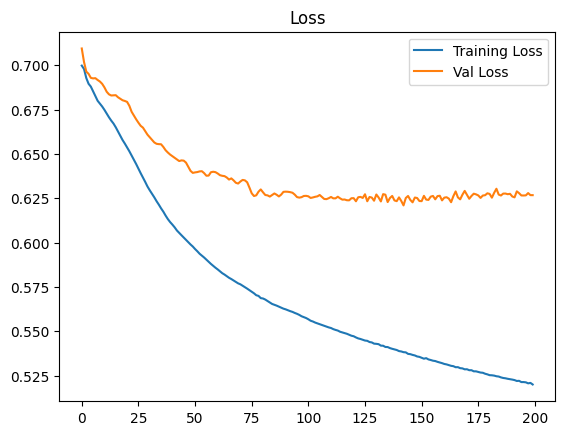

In [16]:
plt.plot(train_losses, label = "Training Loss")
plt.plot(val_losses, label = "Val Loss")
plt.title('Loss')
plt.legend()
plt.show()

In [17]:
#RNNbased, LSTMbased, GRUbased, BI_RNNbased, BI_LSTMbased, BI_GRUbased
train_losses = []
val_losses = []
BI_RNNmodel = BI_RNNbased().cuda()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(BI_RNNmodel.parameters(), lr=1e-3)
epoch(BI_RNNmodel, optimizer, loss_fn)

100%|██████████| 1/1 [00:00<00:00, 37.72it/s]


Accuracy: 0.5431619786614937
Precision: 0.6449507389162561
Recall: 0.5089029076276058
f1_score: 0.373955251300497


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.5470417070805044
Precision: 0.6876439618295492
Recall: 0.5129402287374059
f1_score: 0.3809798085638431


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.5819592628516004
Precision: 0.638251162256787
Recall: 0.5546598438776437
f1_score: 0.48989515759651114


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Accuracy: 0.6265761396702231
Precision: 0.6324547707886774
Recall: 0.6135820398777647
f1_score: 0.6062953466804866


100%|██████████| 1/1 [00:00<00:00, 39.85it/s]


Accuracy: 0.6071774975751697
Precision: 0.6048697235180338
Recall: 0.604577017336843
f1_score: 0.6046767912883189


100%|██████████| 1/1 [00:00<00:00, 34.48it/s]


Accuracy: 0.6197866149369544
Precision: 0.6174455716402598
Recall: 0.6169045565943542
f1_score: 0.6170598223219429


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6323957322987391
Precision: 0.6309489911333634
Recall: 0.6252288130465039
f1_score: 0.624446279101283


100%|██████████| 1/1 [00:00<00:00, 44.42it/s]


Accuracy: 0.6333656644034917
Precision: 0.6402491106336515
Recall: 0.6204747965265801
f1_score: 0.6136325782811459


100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


Accuracy: 0.635305528612997
Precision: 0.6523698377260383
Recall: 0.6192494175667907
f1_score: 0.6064885496183205


100%|██████████| 1/1 [00:00<00:00, 41.51it/s]


Accuracy: 0.6304558680892337
Precision: 0.6485396665481411
Recall: 0.6137541224168709
f1_score: 0.5991794019899653


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6391852570320078
Precision: 0.6567965367965368
Recall: 0.6232867386765907
f1_score: 0.6111138150049887


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6391852570320078
Precision: 0.6485128617363344
Recall: 0.6257715349006081
f1_score: 0.6183305469309768


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6459747817652765
Precision: 0.6490740202711116
Recall: 0.6358393089467792
f1_score: 0.6329797868968375


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6450048496605237
Precision: 0.6447669641931291
Recall: 0.6372802638346797
f1_score: 0.6363561020738571


100%|██████████| 1/1 [00:00<00:00, 13.42it/s]


Accuracy: 0.6450048496605237
Precision: 0.6440342365794975
Recall: 0.6381085292426856
f1_score: 0.6376383778011662


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.646944713870029
Precision: 0.6471161777542864
Recall: 0.6389538138029107
f1_score: 0.6378937699248933


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


Accuracy: 0.6479146459747818
Precision: 0.6498609804963813
Recall: 0.6386172127923513
f1_score: 0.6365900623108317


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6479146459747818
Precision: 0.6527931310915152
Recall: 0.6369606819763396
f1_score: 0.6332740501212611


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6411251212415131
Precision: 0.64701807825017
Recall: 0.6292396599195182
f1_score: 0.6241674876847291


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6440349175557711
Precision: 0.6495790534252073
Recall: 0.6325092281625366
f1_score: 0.6280082385846937


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Accuracy: 0.6450048496605237
Precision: 0.6488666834255069
Recall: 0.6343813349066594
f1_score: 0.6309791112501957


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]

Accuracy: 0.6459747817652765
Precision: 0.6483866583191921
Recall: 0.6362534416507821
f1_score: 0.6337983898670421



100%|██████████| 1/1 [00:00<00:00, 41.66it/s]

Accuracy: 0.646944713870029
Precision: 0.6483130081300813
Recall: 0.6379875041602372
f1_score: 0.6362229942460103



100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6479146459747818
Precision: 0.6487205446962302
Recall: 0.639445478200357
f1_score: 0.6380745429911775


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.646944713870029
Precision: 0.6477670098929942
Recall: 0.6384016368642401
f1_score: 0.6369577835390627


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6479146459747818
Precision: 0.6492650641546207
Recall: 0.6390313454963541
f1_score: 0.6373464730592016


100%|██████████| 1/1 [00:00<00:00, 39.86it/s]


Accuracy: 0.6547041707080504
Precision: 0.6566951219512196
Recall: 0.6457860579105019
f1_score: 0.6442180932735704


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]

Accuracy: 0.6527643064985451
Precision: 0.6552411596623519
Recall: 0.6434222867689329
f1_score: 0.6414686363495073



100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6585838991270611
Precision: 0.6615720613399487
Recall: 0.6492712020816314
f1_score: 0.6474775418855492


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6595538312318138
Precision: 0.6618239402306318
Recall: 0.6507291761217513
f1_score: 0.6493350194043519


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Accuracy: 0.6595538312318138
Precision: 0.6618239402306318
Recall: 0.6507291761217513
f1_score: 0.6493350194043519


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6634335596508244
Precision: 0.6653550770819384
Recall: 0.6550425857008866
f1_score: 0.6540271802147068


100%|██████████| 1/1 [00:00<00:00, 42.39it/s]


Accuracy: 0.6653734238603298
Precision: 0.6664450991664271
Recall: 0.6576824453117909
f1_score: 0.6571155075234176


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6673132880698351
Precision: 0.6683195339830583
Recall: 0.6597701279840247
f1_score: 0.6593121174724013


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6682832201745877
Precision: 0.6690796112801849
Recall: 0.6609520135548093
f1_score: 0.6606123957587378


100%|██████████| 1/1 [00:00<00:00, 44.42it/s]


Accuracy: 0.6624636275460718
Precision: 0.6634470907928389
Recall: 0.6546889655381077
f1_score: 0.654026845637584


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Accuracy: 0.6653734238603298
Precision: 0.6676509822944459
Recall: 0.656854179903785
f1_score: 0.6557935777552626


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6634335596508244
Precision: 0.6657855076691217
Recall: 0.6547664972315512
f1_score: 0.6535661891089732


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6634335596508244
Precision: 0.6651492465224111
Recall: 0.6551806299355541
f1_score: 0.6542532063703144


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6644034917555771
Precision: 0.6658862567608776
Recall: 0.6563625155063386
f1_score: 0.655582117450779


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6673132880698351
Precision: 0.6688885860415898
Recall: 0.6593559952800218
f1_score: 0.6586768204697582


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6673132880698351
Precision: 0.6692990082431736
Recall: 0.6590799068106865
f1_score: 0.6582387601873714


100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


Accuracy: 0.6711930164888458
Precision: 0.6728169126765071
Recall: 0.6633933163898218
f1_score: 0.6628694233816944


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6760426770126091
Precision: 0.6767338116988826
Recall: 0.6691647000090768
f1_score: 0.6691321726430686


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6760426770126091
Precision: 0.6761027391884467
Recall: 0.6697168769477475
f1_score: 0.6698680829850059


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6760426770126091
Precision: 0.6767338116988826
Recall: 0.6691647000090768
f1_score: 0.6691321726430686


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6789524733268671
Precision: 0.6802476045313455
Recall: 0.671744047078757
f1_score: 0.6716260362089785


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6799224054316197
Precision: 0.6811748516861775
Recall: 0.6727878884148739
f1_score: 0.6727147848303885


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6770126091173618
Precision: 0.6771886414516319
Recall: 0.6706226740491967
f1_score: 0.6707671771207628


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6741028128031038
Precision: 0.6738069159755906
Recall: 0.6680433269795165
f1_score: 0.6682449204743955


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6741028128031038
Precision: 0.6738069159755906
Recall: 0.6680433269795165
f1_score: 0.6682449204743955


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6770126091173618
Precision: 0.6773420042174173
Recall: 0.670484629814529
f1_score: 0.6705864856436949


100%|██████████| 1/1 [00:00<00:00, 13.22it/s]


Accuracy: 0.6779825412221144
Precision: 0.6786001656608684
Recall: 0.6712523826813106
f1_score: 0.67130038642073


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6750727449078564
Precision: 0.6750199978041627
Recall: 0.6688110798462982
f1_score: 0.6689688420402911


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6770126091173618
Precision: 0.6767647748592871
Recall: 0.6710368067531995
f1_score: 0.6712929585960277


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6741028128031038
Precision: 0.6739403841181034
Recall: 0.6679052827448488
f1_score: 0.6680694492353685


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6789524733268671
Precision: 0.6789181719243026
Recall: 0.6728484009560982
f1_score: 0.6730956579881351


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6838021338506305
Precision: 0.6838894539195743
Recall: 0.6777915191673474
f1_score: 0.6781185835555147


100%|██████████| 1/1 [00:00<00:00, 13.05it/s]


Accuracy: 0.6828322017458778
Precision: 0.6824119253846334
Recall: 0.6772998547699011
f1_score: 0.6777080877692601


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6799224054316197
Precision: 0.679856438741981
Recall: 0.6738922422922151
f1_score: 0.674169118323067


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6789524733268671
Precision: 0.6792133066258199
Recall: 0.6725723124867629
f1_score: 0.6727445514323498


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6770126091173618
Precision: 0.6770413444798218
Recall: 0.6707607182838644
f1_score: 0.6709451474609458


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6789524733268671
Precision: 0.6787797060662915
Recall: 0.6729864451907658
f1_score: 0.6732671750609163


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6779825412221144
Precision: 0.6779798146015029
Recall: 0.6718045596199813
f1_score: 0.6720210034111378


100%|██████████| 1/1 [00:00<00:00, 13.42it/s]


Accuracy: 0.6828322017458778
Precision: 0.6829543764044503
Recall: 0.6767476778312305
f1_score: 0.677046163631783


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6857419980601358
Precision: 0.6859059615083711
Recall: 0.6797411576049136
f1_score: 0.6800933161717385


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6828322017458778
Precision: 0.6832626369741959
Recall: 0.6764715893618952
f1_score: 0.6766993000555238


100%|██████████| 1/1 [00:00<00:00, 44.43it/s]


Accuracy: 0.6847720659553831
Precision: 0.6845471903982543
Recall: 0.6791114489727996
f1_score: 0.6795187544773643


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6799224054316197
Precision: 0.678837078174361
Recall: 0.6751346404042238
f1_score: 0.6756006864988559


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6828322017458778
Precision: 0.6820686288185243
Recall: 0.677713987473904
f1_score: 0.678176949841779


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6847720659553831
Precision: 0.6844177775702536
Recall: 0.6792494932074673
f1_score: 0.6796792921254114


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]

Accuracy: 0.6808923375363725
Precision: 0.6805295768061725
Recall: 0.6752121720976673
f1_score: 0.6755743699170857



100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6808923375363725
Precision: 0.6807946372732958
Recall: 0.674936083628332
f1_score: 0.6752413915258051


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6779825412221144
Precision: 0.6779798146015029
Recall: 0.6718045596199813
f1_score: 0.6720210034111378


100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


Accuracy: 0.6789524733268671
Precision: 0.6787797060662915
Recall: 0.6729864451907658
f1_score: 0.6732671750609163


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]

Accuracy: 0.6770126091173618
Precision: 0.6760763937322732
Recall: 0.6718650721612054
f1_score: 0.6722719397471326



100%|██████████| 1/1 [00:00<00:00, 43.31it/s]


Accuracy: 0.6750727449078564
Precision: 0.6743885166421528
Recall: 0.6695013010196363
f1_score: 0.6698232703446547


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6750727449078564
Precision: 0.6741764637411245
Recall: 0.6697773894889716
f1_score: 0.6701461676941223


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6808923375363725
Precision: 0.6806590850550669
Recall: 0.6750741278629997
f1_score: 0.67540920856838


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


Accuracy: 0.6799224054316197
Precision: 0.6799995298432027
Recall: 0.6737541980575474
f1_score: 0.6739967804990228


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Accuracy: 0.6789524733268671
Precision: 0.6789181719243026
Recall: 0.6728484009560982
f1_score: 0.6730956579881351


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6808923375363725
Precision: 0.6807946372732958
Recall: 0.674936083628332
f1_score: 0.6752413915258051


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6789524733268671
Precision: 0.678400221013393
Recall: 0.6734005778947687
f1_score: 0.6737656790569575


100%|██████████| 1/1 [00:00<00:00, 43.37it/s]

Accuracy: 0.6789524733268671
Precision: 0.678647252121108
Recall: 0.6731244894254335
f1_score: 0.673436012267884



100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6789524733268671
Precision: 0.678647252121108
Recall: 0.6731244894254335
f1_score: 0.673436012267884


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6789524733268671
Precision: 0.678647252121108
Recall: 0.6731244894254335
f1_score: 0.673436012267884


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Accuracy: 0.6779825412221144
Precision: 0.6775781115946777
Recall: 0.6722186923239841
f1_score: 0.6725330822981961


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]

Accuracy: 0.6750727449078564
Precision: 0.6743885166421528
Recall: 0.6695013010196363
f1_score: 0.6698232703446547



100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6711930164888458
Precision: 0.6705999203852728
Recall: 0.6653259356751686
f1_score: 0.6655432270658992


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6721629485935985
Precision: 0.6715471789352176
Recall: 0.6663697770112855
f1_score: 0.6666150054722599


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6721629485935985
Precision: 0.6714341341848059
Recall: 0.6665078212459532
f1_score: 0.6667833237712755


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6731328806983511
Precision: 0.6723826644565327
Recall: 0.6675516625820701
f1_score: 0.6678520659885036


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6741028128031038
Precision: 0.6738069159755906
Recall: 0.6680433269795165
f1_score: 0.6682449204743955


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6750727449078564
Precision: 0.6742796307233223
Recall: 0.6696393452543039
f1_score: 0.6699860593152724


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6711930164888458
Precision: 0.6701761533387653
Recall: 0.6658781126138392
f1_score: 0.6662076144725595


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6702230843840931
Precision: 0.6693223528679855
Recall: 0.6646962270430546
f1_score: 0.6649782093432219


100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


Accuracy: 0.6721629485935985
Precision: 0.6711288521488282
Recall: 0.6669219539499561
f1_score: 0.6672720120381616


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6770126091173618
Precision: 0.6766354191871493
Recall: 0.6711748509878672
f1_score: 0.6714628159673878


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6750727449078564
Precision: 0.67450315641805
Recall: 0.6693632567849687
f1_score: 0.6696577930766678


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6741028128031038
Precision: 0.6730343300110742
Recall: 0.6690096366221899
f1_score: 0.6693973843135159


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6760426770126091
Precision: 0.675448775359215
Recall: 0.6704070981210857
f1_score: 0.6707267163893671


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6750727449078564
Precision: 0.6743885166421528
Recall: 0.6695013010196363
f1_score: 0.6698232703446547


100%|██████████| 1/1 [00:00<00:00, 13.42it/s]


Accuracy: 0.6741028128031038
Precision: 0.6733311559039443
Recall: 0.668595503918187
f1_score: 0.6689196421744782


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6702230843840931
Precision: 0.6694268135976014
Recall: 0.6645581828083871
f1_score: 0.6648116274622299


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]

Accuracy: 0.6741028128031038
Precision: 0.6735574898217044
Recall: 0.6683194154488518
f1_score: 0.6685876977475719



100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6741028128031038
Precision: 0.6734414547720105
Recall: 0.6684574596835193
f1_score: 0.6687550200803212


100%|██████████| 1/1 [00:00<00:00, 40.79it/s]


Accuracy: 0.6741028128031038
Precision: 0.6735574898217044
Recall: 0.6683194154488518
f1_score: 0.6685876977475719


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6750727449078564
Precision: 0.67450315641805
Recall: 0.6693632567849687
f1_score: 0.6696577930766678


100%|██████████| 1/1 [00:00<00:00, 12.58it/s]


Accuracy: 0.6750727449078564
Precision: 0.6739871531942886
Recall: 0.6700534779583068
f1_score: 0.6704583728103947


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6760426770126091
Precision: 0.6751264016626084
Recall: 0.6708212308250885
f1_score: 0.6712096213631538


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6760426770126091
Precision: 0.675567800708191
Recall: 0.670269053886418
f1_score: 0.670560390022884


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6750727449078564
Precision: 0.6740789820368562
Recall: 0.6699154337236393
f1_score: 0.6703036030489173


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6750727449078564
Precision: 0.6741764637411245
Recall: 0.6697773894889716
f1_score: 0.6701461676941223


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6789524733268671
Precision: 0.678647252121108
Recall: 0.6731244894254335
f1_score: 0.673436012267884


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6770126091173618
Precision: 0.6760763937322732
Recall: 0.6718650721612054
f1_score: 0.6722719397471326


100%|██████████| 1/1 [00:00<00:00, 35.07it/s]


Accuracy: 0.6770126091173618
Precision: 0.6759818906473707
Recall: 0.6720031163958731
f1_score: 0.6724257855100341


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6770126091173618
Precision: 0.6762825992353362
Recall: 0.6715889836918701
f1_score: 0.6719562917969724


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6731328806983511
Precision: 0.6722766622113083
Recall: 0.6676897068167378
f1_score: 0.6680158268335726


100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


Accuracy: 0.6770126091173618
Precision: 0.6762825992353362
Recall: 0.6715889836918701
f1_score: 0.6719562917969724


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6770126091173618
Precision: 0.6760763937322732
Recall: 0.6718650721612054
f1_score: 0.6722719397471326


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6779825412221144
Precision: 0.6774560959464195
Recall: 0.6723567365586518
f1_score: 0.6726984126984127


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6770126091173618
Precision: 0.6762825992353362
Recall: 0.6715889836918701
f1_score: 0.6719562917969724


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6760426770126091
Precision: 0.6747762863534675
Recall: 0.6713734077637591
f1_score: 0.6718162688035133


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6741028128031038
Precision: 0.6733311559039443
Recall: 0.668595503918187
f1_score: 0.6689196421744782


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]

Accuracy: 0.6741028128031038
Precision: 0.6736792976042618
Recall: 0.6681813712141842
f1_score: 0.6684176672384219



100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6770126091173618
Precision: 0.6758930779694553
Recall: 0.6721411606305406
f1_score: 0.672576988844712


100%|██████████| 1/1 [00:00<00:00, 44.42it/s]


Accuracy: 0.6808923375363725
Precision: 0.680288536259364
Recall: 0.6754882605670025
f1_score: 0.6758967567603722


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6770126091173618
Precision: 0.6760763937322732
Recall: 0.6718650721612054
f1_score: 0.6722719397471326


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6741028128031038
Precision: 0.6728645137370912
Recall: 0.6692857250915252
f1_score: 0.6697025171624713


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6789524733268671
Precision: 0.67828556774735
Recall: 0.6735386221294364
f1_score: 0.6739265242786723


100%|██████████| 1/1 [00:00<00:00, 13.51it/s]


Accuracy: 0.6808923375363725
Precision: 0.6806590850550669
Recall: 0.6750741278629997
f1_score: 0.67540920856838


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6760426770126091
Precision: 0.6748553685495146
Recall: 0.6712353635290913
f1_score: 0.6716685736079329


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6799224054316197
Precision: 0.6789269141531322
Recall: 0.6749965961695561
f1_score: 0.6754521520146521


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6838021338506305
Precision: 0.6829137664346481
Recall: 0.6788958730446886
f1_score: 0.6793860653235654


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6828322017458778
Precision: 0.6820686288185243
Recall: 0.677713987473904
f1_score: 0.678176949841779


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6779825412221144
Precision: 0.6768462233619378
Recall: 0.6731850019666576
f1_score: 0.6736346300533944


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6789524733268671
Precision: 0.678400221013393
Recall: 0.6734005778947687
f1_score: 0.6737656790569575


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6799224054316197
Precision: 0.6791239511763885
Recall: 0.6747205077002209
f1_score: 0.675147230688146


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6789524733268671
Precision: 0.6779766281004527
Recall: 0.6739527548334392
f1_score: 0.6743931982096735


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6731328806983511
Precision: 0.6719924157412065
Recall: 0.6681038395207406
f1_score: 0.6684909601107552


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Accuracy: 0.6731328806983511
Precision: 0.6719088140728374
Recall: 0.6682418837554083
f1_score: 0.6686439797017055


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6799224054316197
Precision: 0.6791239511763885
Recall: 0.6747205077002209
f1_score: 0.675147230688146


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6779825412221144
Precision: 0.677339958939903
Recall: 0.6724947807933195
f1_score: 0.6728610750057344


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6808923375363725
Precision: 0.6800712171231071
Recall: 0.6757643490363378
f1_score: 0.6762086131435635


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6731328806983511
Precision: 0.6719924157412065
Recall: 0.6681038395207406
f1_score: 0.6684909601107552


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6741028128031038
Precision: 0.6732265579499126
Recall: 0.6687335481528547
f1_score: 0.6690815718281444


100%|██████████| 1/1 [00:00<00:00, 13.15it/s]


Accuracy: 0.6779825412221144
Precision: 0.677339958939903
Recall: 0.6724947807933195
f1_score: 0.6728610750057344


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6799224054316197
Precision: 0.6791239511763885
Recall: 0.6747205077002209
f1_score: 0.675147230688146


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6750727449078564
Precision: 0.6738203305313047
Recall: 0.6703295664276421
f1_score: 0.6707599445968064


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6760426770126091
Precision: 0.6751264016626084
Recall: 0.6708212308250885
f1_score: 0.6712096213631538


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6779825412221144
Precision: 0.6771251764194984
Recall: 0.6727708692626546
f1_score: 0.6731784260256499


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6770126091173618
Precision: 0.6759818906473707
Recall: 0.6720031163958731
f1_score: 0.6724257855100341


100%|██████████| 1/1 [00:00<00:00, 13.42it/s]


Accuracy: 0.6779825412221144
Precision: 0.6770264619101829
Recall: 0.6729089134973223
f1_score: 0.6733331297383549


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6741028128031038
Precision: 0.6731276269057183
Recall: 0.6688715923875224
f1_score: 0.6692408167006576


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6770126091173618
Precision: 0.6762825992353362
Recall: 0.6715889836918701
f1_score: 0.6719562917969724


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6808923375363725
Precision: 0.6800712171231071
Recall: 0.6757643490363378
f1_score: 0.6762086131435635


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6760426770126091
Precision: 0.6748553685495146
Recall: 0.6712353635290913
f1_score: 0.6716685736079329


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6702230843840931
Precision: 0.6688828041122448
Recall: 0.6653864482163929
f1_score: 0.6657704042715484


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6731328806983511
Precision: 0.6721763085399448
Recall: 0.6678277510514055
f1_score: 0.6681768910833409


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6711930164888458
Precision: 0.6702736936992943
Recall: 0.6657400683791715
f1_score: 0.6660455943518727


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6741028128031038
Precision: 0.6729466357308584
Recall: 0.6691476808568575
f1_score: 0.6695512820512821


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6721629485935985
Precision: 0.6706099388908106
Recall: 0.6678882635926295
f1_score: 0.6683183583339678


100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


Accuracy: 0.6779825412221144
Precision: 0.6771251764194984
Recall: 0.6727708692626546
f1_score: 0.6731784260256499


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6770126091173618
Precision: 0.6760763937322732
Recall: 0.6718650721612054
f1_score: 0.6722719397471326


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6789524733268671
Precision: 0.6778852099177641
Recall: 0.6740907990681069
f1_score: 0.6745434934162153


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6741028128031038
Precision: 0.6732265579499126
Recall: 0.6687335481528547
f1_score: 0.6690815718281444


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6770126091173618
Precision: 0.6762825992353362
Recall: 0.6715889836918701
f1_score: 0.6719562917969724


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6731328806983511
Precision: 0.6717581528024054
Recall: 0.6685179722247436
f1_score: 0.6689420250499045


100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


Accuracy: 0.6731328806983511
Precision: 0.6718307358605624
Recall: 0.668379927990076
f1_score: 0.6687943323257426


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6741028128031038
Precision: 0.6730343300110742
Recall: 0.6690096366221899
f1_score: 0.6693973843135159


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6750727449078564
Precision: 0.6739871531942886
Recall: 0.6700534779583068
f1_score: 0.6704583728103947


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6760426770126091
Precision: 0.6749400618716164
Recall: 0.6710973192944237
f1_score: 0.6715182387057387


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6760426770126091
Precision: 0.675448775359215
Recall: 0.6704070981210857
f1_score: 0.6707267163893671


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6741028128031038
Precision: 0.6733311559039443
Recall: 0.668595503918187
f1_score: 0.6689196421744782


100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


Accuracy: 0.6750727449078564
Precision: 0.6739871531942886
Recall: 0.6700534779583068
f1_score: 0.6704583728103947


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]

Accuracy: 0.6731328806983511
Precision: 0.6717581528024054
Recall: 0.6685179722247436
f1_score: 0.6689420250499045



100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6750727449078564
Precision: 0.6739871531942886
Recall: 0.6700534779583068
f1_score: 0.6704583728103947


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6731328806983511
Precision: 0.6720815703414392
Recall: 0.667965795286073
f1_score: 0.6683352663507018


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6750727449078564
Precision: 0.6739871531942886
Recall: 0.6700534779583068
f1_score: 0.6704583728103947


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6750727449078564
Precision: 0.6739871531942886
Recall: 0.6700534779583068
f1_score: 0.6704583728103947


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6741028128031038
Precision: 0.6728645137370912
Recall: 0.6692857250915252
f1_score: 0.6697025171624713


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6750727449078564
Precision: 0.6737452779276849
Recall: 0.6704676106623098
f1_score: 0.6709067608062849


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6721629485935985
Precision: 0.6710382640615199
Recall: 0.6670599981846237
f1_score: 0.6674295116010964


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6750727449078564
Precision: 0.6741764637411245
Recall: 0.6697773894889716
f1_score: 0.6701461676941223


100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


Accuracy: 0.6741028128031038
Precision: 0.6729466357308584
Recall: 0.6691476808568575
f1_score: 0.6695512820512821


100%|██████████| 1/1 [00:00<00:00, 40.90it/s]


Accuracy: 0.6721629485935985
Precision: 0.670873658924668
Recall: 0.667336086653959
f1_score: 0.66773646071701


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6750727449078564
Precision: 0.6739009460211464
Recall: 0.6701915221929744
f1_score: 0.6706104842732087


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6741028128031038
Precision: 0.672716871229457
Recall: 0.6695618135608605
f1_score: 0.6699970278241387


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6770126091173618
Precision: 0.6758930779694553
Recall: 0.6721411606305406
f1_score: 0.672576988844712


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6760426770126091
Precision: 0.6751264016626084
Recall: 0.6708212308250885
f1_score: 0.6712096213631538


100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


Accuracy: 0.6750727449078564
Precision: 0.6742796307233223
Recall: 0.6696393452543039
f1_score: 0.6699860593152724


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6731328806983511
Precision: 0.6717581528024054
Recall: 0.6685179722247436
f1_score: 0.6689420250499045


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6770126091173618
Precision: 0.6756604834176503
Recall: 0.6725552933345436
f1_score: 0.6730148147795403


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6731328806983511
Precision: 0.6719088140728374
Recall: 0.6682418837554083
f1_score: 0.6686439797017055


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6741028128031038
Precision: 0.6730343300110742
Recall: 0.6690096366221899
f1_score: 0.6693973843135159


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6731328806983511
Precision: 0.6720815703414392
Recall: 0.667965795286073
f1_score: 0.6683352663507018


100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


Accuracy: 0.6692531522793405
Precision: 0.6679245501762197
Recall: 0.664342606880276
f1_score: 0.664710970558699


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6731328806983511
Precision: 0.6718307358605624
Recall: 0.668379927990076
f1_score: 0.6687943323257426


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6663433559650824
Precision: 0.6650500662128569
Recall: 0.6612110828719252
f1_score: 0.6615258934638377


100%|██████████| 1/1 [00:00<00:00, 41.23it/s]

Accuracy: 0.6702230843840931
Precision: 0.6689597834493426
Recall: 0.6652484039817252
f1_score: 0.6656173687423688


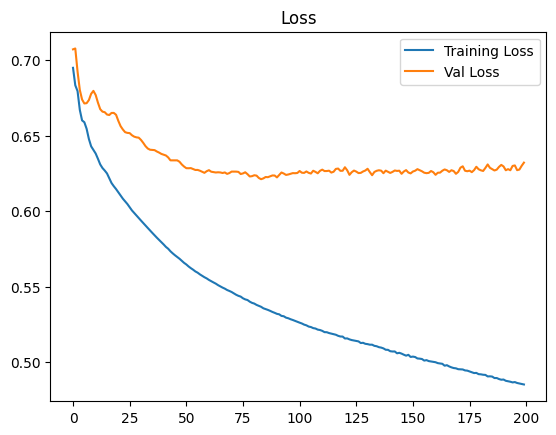

In [18]:
plt.plot(train_losses, label = "Training Loss")
plt.plot(val_losses, label = "Val Loss")
plt.title('Loss')
plt.legend()
plt.show()

In [19]:
#RNNbased, LSTMbased, GRUbased, BI_RNNbased, BI_LSTMbased, BI_GRUbased
train_losses = []
val_losses = []
BI_LSTMmodel = BI_LSTMbased().cuda()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(BI_LSTMmodel.parameters(), lr=1e-3)
epoch(BI_LSTMmodel, optimizer, loss_fn)

100%|██████████| 1/1 [00:00<00:00, 33.32it/s]


Accuracy: 0.550921435499515
Precision: 0.5439908783229999
Recall: 0.5345091676499955
f1_score: 0.5157105218037958


100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


Accuracy: 0.5703200775945684
Precision: 0.6159343622935856
Recall: 0.5422717920789083
f1_score: 0.4703052570173393


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.5683802133850631
Precision: 0.6294375722834011
Recall: 0.5389417112946658
f1_score: 0.4563634489304297


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.574199806013579
Precision: 0.6411323650962333
Recall: 0.5452047593113672
f1_score: 0.467216076900168


100%|██████████| 1/1 [00:00<00:00, 38.33it/s]


Accuracy: 0.5897187196896218
Precision: 0.6467464702271333
Recall: 0.5632866630359142
f1_score: 0.5052519328179153


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.5984481086323957
Precision: 0.6351455188358492
Recall: 0.5751660312849838
f1_score: 0.5349378949662236


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6091173617846751
Precision: 0.6358476886491503
Recall: 0.5885809052676167
f1_score: 0.5607882477428575


100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


Accuracy: 0.612027158098933
Precision: 0.6250211474349405
Recall: 0.5950254909079907
f1_score: 0.5784437993212577


100%|██████████| 1/1 [00:00<00:00, 35.07it/s]


Accuracy: 0.6178467507274491
Precision: 0.623776252092069
Recall: 0.6040494236180448
f1_score: 0.5949751529509361


100%|██████████| 1/1 [00:00<00:00, 38.33it/s]


Accuracy: 0.6168768186226964
Precision: 0.6179929116914897
Recall: 0.6057664669752806
f1_score: 0.6009455917297468


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6246362754607178
Precision: 0.6232274599980837
Recall: 0.6167400381229009
f1_score: 0.6153730475697466


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6304558680892337
Precision: 0.6288253825382538
Recall: 0.6234172188436053
f1_score: 0.6226806025030329


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6372453928225025
Precision: 0.6356428066870732
Recall: 0.6307241081964237
f1_score: 0.6303313264562642


100%|██████████| 1/1 [00:00<00:00, 12.62it/s]


Accuracy: 0.6450048496605237
Precision: 0.644502538756764
Recall: 0.637556352304015
f1_score: 0.6367957217768948


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6411251212415131
Precision: 0.6413648744479902
Recall: 0.6326907657862092
f1_score: 0.6312161639597835


100%|██████████| 1/1 [00:00<00:00, 39.96it/s]


Accuracy: 0.6479146459747818
Precision: 0.6509728431859579
Recall: 0.6379269916190131
f1_score: 0.6352654768506292


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6411251212415131
Precision: 0.6464224937788077
Recall: 0.6295157483888536
f1_score: 0.6248091933402574


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6401551891367604
Precision: 0.6470064830526912
Recall: 0.6277816858793985
f1_score: 0.6219916294835875


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6391852570320078
Precision: 0.6454095549840231
Recall: 0.6270139330126169
f1_score: 0.6214766213463453


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6362754607177498
Precision: 0.6402469041495853
Recall: 0.6249867628816073
f1_score: 0.6205321432462328


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6372453928225025
Precision: 0.6404641665756372
Recall: 0.626444736921727
f1_score: 0.6226148811061785


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.635305528612997
Precision: 0.6370012816802415
Recall: 0.6253233638921667
f1_score: 0.6223443223443224


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6391852570320078
Precision: 0.6399308943089431
Recall: 0.6301889504099725
f1_score: 0.62822789521845


100%|██████████| 1/1 [00:00<00:00, 12.64it/s]


Accuracy: 0.6372453928225025
Precision: 0.6380045144519504
Recall: 0.6281012677377387
f1_score: 0.6259709773794281


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6372453928225025
Precision: 0.6385439578477397
Recall: 0.6276871350337357
f1_score: 0.6251769161378624


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6362754607177498
Precision: 0.6388082183778552
Recall: 0.625815028289613
f1_score: 0.6223469045877099


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6372453928225025
Precision: 0.640227501256913
Recall: 0.6265827811563947
f1_score: 0.6229130808950085


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6498545101842871
Precision: 0.6536059092800666
Recall: 0.639600541587244
f1_score: 0.6367255708631636


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6605237633365665
Precision: 0.6639288762680149
Recall: 0.65108279628453
f1_score: 0.6492297343536144


100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


Accuracy: 0.6576139670223085
Precision: 0.6593156277791252
Recall: 0.6490556261535203
f1_score: 0.6478119795582832


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6644034917555771
Precision: 0.6655071131713555
Recall: 0.656638603975674
f1_score: 0.6560151970994368


100%|██████████| 1/1 [00:00<00:00, 39.89it/s]


Accuracy: 0.6702230843840931
Precision: 0.6711277006571368
Recall: 0.6629016519923754
f1_score: 0.662597118590558


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6692531522793405
Precision: 0.6707548301932078
Recall: 0.6614436779522557
f1_score: 0.6608804524281939


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6653734238603298
Precision: 0.6681033782686374
Recall: 0.6565780914344498
f1_score: 0.6553292925769271


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6682832201745877
Precision: 0.6713638211382114
Recall: 0.6594335269734652
f1_score: 0.6582095165718007


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Accuracy: 0.6731328806983511
Precision: 0.675751659823006
Recall: 0.6647907778887174
f1_score: 0.6639975784794128


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6673132880698351
Precision: 0.6679705795962434
Recall: 0.6600462164533599
f1_score: 0.6597212399386092


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6653734238603298
Precision: 0.6651736537311554
Recall: 0.658786799189132
f1_score: 0.6587157283695939


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6673132880698351
Precision: 0.6672017121455324
Recall: 0.6607364376266982
f1_score: 0.6606941879152773


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6711930164888458
Precision: 0.6722421061003738
Recall: 0.6638074490938246
f1_score: 0.6634887471416536


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6731328806983511
Precision: 0.6746770304365878
Recall: 0.6654809990620556
f1_score: 0.6650664522764977


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6721629485935985
Precision: 0.6733600031844598
Recall: 0.6647132461952739
f1_score: 0.6643802633505149


100%|██████████| 1/1 [00:00<00:00, 37.72it/s]


Accuracy: 0.6779825412221144
Precision: 0.6793200581649437
Recall: 0.6707002057426401
f1_score: 0.670536009917839


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6799224054316197
Precision: 0.6808075579649444
Recall: 0.6730639768842093
f1_score: 0.6730946615934509


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6799224054316197
Precision: 0.6808075579649444
Recall: 0.6730639768842093
f1_score: 0.6730946615934509


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Accuracy: 0.6818622696411252
Precision: 0.6828444310979753
Recall: 0.6750136153217754
f1_score: 0.6750759060686421


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6789524733268671
Precision: 0.6793700626317942
Recall: 0.6724342682520952
f1_score: 0.6725649451893785


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6789524733268671
Precision: 0.6789181719243026
Recall: 0.6728484009560982
f1_score: 0.6730956579881351


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6789524733268671
Precision: 0.6792133066258199
Recall: 0.6725723124867629
f1_score: 0.6727445514323498


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6828322017458778
Precision: 0.6835960591133006
Recall: 0.67619550089256
f1_score: 0.6763417479083564


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6779825412221144
Precision: 0.678435865935866
Recall: 0.6713904269159783
f1_score: 0.6714846209364107


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Accuracy: 0.6750727449078564
Precision: 0.6746235862531904
Recall: 0.6692252125503011
f1_score: 0.6694896196668916


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


Accuracy: 0.6770126091173618
Precision: 0.6766354191871493
Recall: 0.6711748509878672
f1_score: 0.6714628159673878


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6789524733268671
Precision: 0.6789181719243026
Recall: 0.6728484009560982
f1_score: 0.6730956579881351


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6770126091173618
Precision: 0.6766354191871493
Recall: 0.6711748509878672
f1_score: 0.6714628159673878


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6741028128031038
Precision: 0.6735574898217044
Recall: 0.6683194154488518
f1_score: 0.6685876977475719


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6779825412221144
Precision: 0.6774560959464195
Recall: 0.6723567365586518
f1_score: 0.6726984126984127


100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


Accuracy: 0.6799224054316197
Precision: 0.6791239511763885
Recall: 0.6747205077002209
f1_score: 0.675147230688146


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]

Accuracy: 0.6799224054316197
Precision: 0.6789269141531322
Recall: 0.6749965961695561
f1_score: 0.6754521520146521



100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6770126091173618
Precision: 0.6760763937322732
Recall: 0.6718650721612054
f1_score: 0.6722719397471326


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6702230843840931
Precision: 0.6688828041122448
Recall: 0.6653864482163929
f1_score: 0.6657704042715484


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6731328806983511
Precision: 0.6719088140728374
Recall: 0.6682418837554083
f1_score: 0.6686439797017055


100%|██████████| 1/1 [00:00<00:00, 28.56it/s]


Accuracy: 0.6721629485935985
Precision: 0.6709532095901005
Recall: 0.6671980424192914
f1_score: 0.6675843253968253


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6702230843840931
Precision: 0.6689597834493426
Recall: 0.6652484039817252
f1_score: 0.6656173687423688


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6702230843840931
Precision: 0.6688112319679087
Recall: 0.6655244924510605
f1_score: 0.665920752674235


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6711930164888458
Precision: 0.6699166821245286
Recall: 0.6662922453178421
f1_score: 0.6666774751302023


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6711930164888458
Precision: 0.6700841586460222
Recall: 0.6660161568485068
f1_score: 0.6663669296524863


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Accuracy: 0.6731328806983511
Precision: 0.6719088140728374
Recall: 0.6682418837554083
f1_score: 0.6686439797017055


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6692531522793405
Precision: 0.6677839025518464
Recall: 0.6646186953496112
f1_score: 0.6650125535371437


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6673132880698351
Precision: 0.6659324182279107
Recall: 0.6623929684427098
f1_score: 0.6627444659871957


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6673132880698351
Precision: 0.6659324182279107
Recall: 0.6623929684427098
f1_score: 0.6627444659871957


100%|██████████| 1/1 [00:00<00:00, 39.85it/s]


Accuracy: 0.6682832201745877
Precision: 0.6669663573085847
Recall: 0.6632987655441591
f1_score: 0.6636504120879121


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6702230843840931
Precision: 0.6689597834493426
Recall: 0.6652484039817252
f1_score: 0.6656173687423688


100%|██████████| 1/1 [00:00<00:00, 13.15it/s]


Accuracy: 0.6721629485935985
Precision: 0.6710382640615199
Recall: 0.6670599981846237
f1_score: 0.6674295116010964


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6692531522793405
Precision: 0.6677839025518464
Recall: 0.6646186953496112
f1_score: 0.6650125535371437


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6682832201745877
Precision: 0.6668919492998215
Recall: 0.6634368097788267
f1_score: 0.6638043478260869


100%|██████████| 1/1 [00:00<00:00, 37.72it/s]


Accuracy: 0.6692531522793405
Precision: 0.6680029408350423
Recall: 0.6642045626456083
f1_score: 0.6645561347114763


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6682832201745877
Precision: 0.6669663573085847
Recall: 0.6632987655441591
f1_score: 0.6636504120879121


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6663433559650824
Precision: 0.6649010944873983
Recall: 0.6614871713412604
f1_score: 0.6618382913806256


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Accuracy: 0.6673132880698351
Precision: 0.6659324182279107
Recall: 0.6623929684427098
f1_score: 0.6627444659871957


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6682832201745877
Precision: 0.6669663573085847
Recall: 0.6632987655441591
f1_score: 0.6636504120879121


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]

Accuracy: 0.6673132880698351
Precision: 0.6659324182279107
Recall: 0.6623929684427098
f1_score: 0.6627444659871957



100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6682832201745877
Precision: 0.6668919492998215
Recall: 0.6634368097788267
f1_score: 0.6638043478260869


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


Accuracy: 0.6692531522793405
Precision: 0.6678515465190777
Recall: 0.6644806511149436
f1_score: 0.6648631077836149


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6692531522793405
Precision: 0.6679245501762197
Recall: 0.664342606880276
f1_score: 0.664710970558699


100%|██████████| 1/1 [00:00<00:00, 39.88it/s]


Accuracy: 0.6673132880698351
Precision: 0.6659324182279107
Recall: 0.6623929684427098
f1_score: 0.6627444659871957


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6721629485935985
Precision: 0.6707995834297616
Recall: 0.6674741308886267
f1_score: 0.6678859247173279


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]

Accuracy: 0.6711930164888458
Precision: 0.6698411411898201
Recall: 0.6664302895525098
f1_score: 0.6668287200546787



100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6682832201745877
Precision: 0.6668228805060556
Recall: 0.6635748540134943
f1_score: 0.6639555806311424


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Accuracy: 0.6702230843840931
Precision: 0.6689597834493426
Recall: 0.6652484039817252
f1_score: 0.6656173687423688


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6692531522793405
Precision: 0.6679245501762197
Recall: 0.664342606880276
f1_score: 0.664710970558699


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6673132880698351
Precision: 0.6659324182279107
Recall: 0.6623929684427098
f1_score: 0.6627444659871957


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6673132880698351
Precision: 0.6656822027380402
Recall: 0.6629451453813803
f1_score: 0.6633403686345518


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6682832201745877
Precision: 0.6667006556670566
Recall: 0.6638509424828296
f1_score: 0.6642499657205541


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6673132880698351
Precision: 0.6657368692585491
Recall: 0.6628071011467127
f1_score: 0.6631954398479949


100%|██████████| 1/1 [00:00<00:00, 13.15it/s]


Accuracy: 0.6692531522793405
Precision: 0.6677839025518464
Recall: 0.6646186953496112
f1_score: 0.6650125535371437


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6692531522793405
Precision: 0.6675664165016806
Recall: 0.6651708722882818
f1_score: 0.665583560116694


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6682832201745877
Precision: 0.6665994840374073
Recall: 0.6641270309521649
f1_score: 0.664533622559653


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6711930164888458
Precision: 0.6695929906506157
Recall: 0.6669824664911803
f1_score: 0.6674070119644748


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6711930164888458
Precision: 0.669500977348511
Recall: 0.6672585549605156
f1_score: 0.667680239606361


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6702230843840931
Precision: 0.6684595014503403
Recall: 0.6664908020937339
f1_score: 0.6668985282491029


100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


Accuracy: 0.6741028128031038
Precision: 0.6724872493001495
Recall: 0.670113990499531
f1_score: 0.6705544016616072


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6731328806983511
Precision: 0.6714017976668579
Recall: 0.6694842818674169
f1_score: 0.669901962554047


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


Accuracy: 0.6711930164888458
Precision: 0.6694025402356825
Recall: 0.6676726876645185
f1_score: 0.6680703273910429


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6731328806983511
Precision: 0.6714017976668579
Recall: 0.6694842818674169
f1_score: 0.669901962554047


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6770126091173618
Precision: 0.6754283086121651
Recall: 0.673107470273214
f1_score: 0.6735620052770448


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6750727449078564
Precision: 0.6734103160989953
Recall: 0.6712958760703156
f1_score: 0.6717325083519856


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6731328806983511
Precision: 0.6714366117373194
Recall: 0.6693462376327494
f1_score: 0.6697727024316991


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]

Accuracy: 0.6741028128031038
Precision: 0.6724048860009644
Recall: 0.6703900789688663
f1_score: 0.6708173690932311



100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6760426770126091
Precision: 0.6744181146762281
Recall: 0.6722016731717648
f1_score: 0.6726473853922672


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6799224054316197
Precision: 0.6784735338830792
Recall: 0.6758248615775619
f1_score: 0.6763043726452791


100%|██████████| 1/1 [00:00<00:00, 12.82it/s]


Accuracy: 0.6731328806983511
Precision: 0.6714017976668579
Recall: 0.6694842818674169
f1_score: 0.669901962554047


100%|██████████| 1/1 [00:00<00:00, 40.79it/s]


Accuracy: 0.6760426770126091
Precision: 0.6745155172678552
Recall: 0.6719255847024296
f1_score: 0.6723807892834037


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6721629485935985
Precision: 0.6704321937256523
Recall: 0.6684404405313
f1_score: 0.668857948671167


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6741028128031038
Precision: 0.6724433820600042
Recall: 0.6702520347341987
f1_score: 0.6706871900952149


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6760426770126091
Precision: 0.6747027868309332
Recall: 0.6715114519984267
f1_score: 0.6719613312299473


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6692531522793405
Precision: 0.6674123332747998
Recall: 0.6658610934616198
f1_score: 0.6662375623838832


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Accuracy: 0.6721629485935985
Precision: 0.6705575006526312
Recall: 0.6680263078272972
f1_score: 0.6684572059215284


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6760426770126091
Precision: 0.6745155172678552
Recall: 0.6719255847024296
f1_score: 0.6723807892834037


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


Accuracy: 0.6721629485935985
Precision: 0.6704321937256523
Recall: 0.6684404405313
f1_score: 0.668857948671167


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


Accuracy: 0.6760426770126091
Precision: 0.6747027868309332
Recall: 0.6715114519984267
f1_score: 0.6719613312299473


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6711930164888458
Precision: 0.6694629073756433
Recall: 0.6673965991951831
f1_score: 0.6678128965114124


100%|██████████| 1/1 [00:00<00:00, 38.42it/s]


Accuracy: 0.6721629485935985
Precision: 0.6705104114737125
Recall: 0.6681643520619649
f1_score: 0.6685934159572121


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Accuracy: 0.6750727449078564
Precision: 0.6736757605858301
Recall: 0.6706056548969774
f1_score: 0.6710509397932312


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6702230843840931
Precision: 0.6684939168275565
Recall: 0.6663527578590662
f1_score: 0.6667667995011103


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6741028128031038
Precision: 0.6729466357308584
Recall: 0.6691476808568575
f1_score: 0.6695512820512821


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6702230843840931
Precision: 0.6685335736472754
Recall: 0.6662147136243987
f1_score: 0.6666324302528169


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6731328806983511
Precision: 0.6715222462667096
Recall: 0.6690701491634141
f1_score: 0.6695063336050612


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


Accuracy: 0.6731328806983511
Precision: 0.6719088140728374
Recall: 0.6682418837554083
f1_score: 0.6686439797017055


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6711930164888458
Precision: 0.669500977348511
Recall: 0.6672585549605156
f1_score: 0.667680239606361


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6731328806983511
Precision: 0.6716293647131211
Recall: 0.6687940606940789
f1_score: 0.6692294583960465


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6741028128031038
Precision: 0.672716871229457
Recall: 0.6695618135608605
f1_score: 0.6699970278241387


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6711930164888458
Precision: 0.669500977348511
Recall: 0.6672585549605156
f1_score: 0.667680239606361


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Accuracy: 0.6770126091173618
Precision: 0.6758930779694553
Recall: 0.6721411606305406
f1_score: 0.672576988844712


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6692531522793405
Precision: 0.6676128724965238
Recall: 0.6650328280536142
f1_score: 0.6654448114450913


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6711930164888458
Precision: 0.6697710276771259
Recall: 0.6665683337871774
f1_score: 0.6669772892935241


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6750727449078564
Precision: 0.6736757605858301
Recall: 0.6706056548969774
f1_score: 0.6710509397932312


100%|██████████| 1/1 [00:00<00:00, 40.79it/s]


Accuracy: 0.6760426770126091
Precision: 0.6747027868309332
Recall: 0.6715114519984267
f1_score: 0.6719613312299473


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6731328806983511
Precision: 0.6718307358605624
Recall: 0.668379927990076
f1_score: 0.6687943323257426


100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


Accuracy: 0.6711930164888458
Precision: 0.6696469773880942
Recall: 0.6668444222565126
f1_score: 0.6672664284755483


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6760426770126091
Precision: 0.6749400618716164
Recall: 0.6710973192944237
f1_score: 0.6715182387057387


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6682832201745877
Precision: 0.6665994840374073
Recall: 0.6641270309521649
f1_score: 0.664533622559653


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]

Accuracy: 0.6731328806983511
Precision: 0.6720815703414392
Recall: 0.667965795286073
f1_score: 0.6683352663507018



100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6682832201745877
Precision: 0.6667006556670566
Recall: 0.6638509424828296
f1_score: 0.6642499657205541


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6702230843840931
Precision: 0.6688828041122448
Recall: 0.6653864482163929
f1_score: 0.6657704042715484


100%|██████████| 1/1 [00:00<00:00, 12.82it/s]


Accuracy: 0.6750727449078564
Precision: 0.6736757605858301
Recall: 0.6706056548969774
f1_score: 0.6710509397932312


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6721629485935985
Precision: 0.670667749184264
Recall: 0.667750219357962
f1_score: 0.6681768667062784


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6682832201745877
Precision: 0.6668919492998215
Recall: 0.6634368097788267
f1_score: 0.6638043478260869


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6711930164888458
Precision: 0.6695443313841951
Recall: 0.667120510725848
f1_score: 0.6675449468608776


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6702230843840931
Precision: 0.6688828041122448
Recall: 0.6653864482163929
f1_score: 0.6657704042715484


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6721629485935985
Precision: 0.670667749184264
Recall: 0.667750219357962
f1_score: 0.6681768667062784


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6711930164888458
Precision: 0.6698411411898201
Recall: 0.6664302895525098
f1_score: 0.6668287200546787


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6721629485935985
Precision: 0.6705575006526312
Recall: 0.6680263078272972
f1_score: 0.6684572059215284


100%|██████████| 1/1 [00:00<00:00, 41.58it/s]


Accuracy: 0.6692531522793405
Precision: 0.6677839025518464
Recall: 0.6646186953496112
f1_score: 0.6650125535371437


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6731328806983511
Precision: 0.6717581528024054
Recall: 0.6685179722247436
f1_score: 0.6689420250499045


100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


Accuracy: 0.6711930164888458
Precision: 0.6696469773880942
Recall: 0.6668444222565126
f1_score: 0.6672664284755483


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6731328806983511
Precision: 0.6719088140728374
Recall: 0.6682418837554083
f1_score: 0.6686439797017055


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6789524733268671
Precision: 0.6775134632669837
Recall: 0.674781020241445
f1_score: 0.6752558140420094


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6760426770126091
Precision: 0.6748553685495146
Recall: 0.6712353635290913
f1_score: 0.6716685736079329


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6760426770126091
Precision: 0.6746348427014714
Recall: 0.6716494962330943
f1_score: 0.672103767692003


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Accuracy: 0.6770126091173618
Precision: 0.6756604834176503
Recall: 0.6725552933345436
f1_score: 0.6730148147795403


100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


Accuracy: 0.6799224054316197
Precision: 0.6786746180338857
Recall: 0.675410728873559
f1_score: 0.6758899380415646


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6828322017458778
Precision: 0.6814118206792823
Recall: 0.6788183413512451
f1_score: 0.6793132673259793


100%|██████████| 1/1 [00:00<00:00, 39.84it/s]


Accuracy: 0.6750727449078564
Precision: 0.6738203305313047
Recall: 0.6703295664276421
f1_score: 0.6707599445968064


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


Accuracy: 0.6750727449078564
Precision: 0.6736757605858301
Recall: 0.6706056548969774
f1_score: 0.6710509397932312


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6779825412221144
Precision: 0.6767646378153205
Recall: 0.6733230462013252
f1_score: 0.6737814408466061


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6799224054316197
Precision: 0.6786019362186788
Recall: 0.6755487731082267
f1_score: 0.6760306686777275


100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


Accuracy: 0.6789524733268671
Precision: 0.6775134632669837
Recall: 0.674781020241445
f1_score: 0.6752558140420094


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6779825412221144
Precision: 0.6766183894600751
Recall: 0.6735991346706605
f1_score: 0.6740672181848653


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6789524733268671
Precision: 0.6775765266882019
Recall: 0.6746429760067774
f1_score: 0.6751185481575412


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6808923375363725
Precision: 0.6794339057967678
Recall: 0.6768687029136788
f1_score: 0.6773518805817956


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6799224054316197
Precision: 0.6784735338830792
Recall: 0.6758248615775619
f1_score: 0.6763043726452791


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6770126091173618
Precision: 0.6756604834176503
Recall: 0.6725552933345436
f1_score: 0.6730148147795403


100%|██████████| 1/1 [00:00<00:00, 37.72it/s]


Accuracy: 0.6779825412221144
Precision: 0.6766183894600751
Recall: 0.6735991346706605
f1_score: 0.6740672181848653


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6808923375363725
Precision: 0.6794339057967678
Recall: 0.6768687029136788
f1_score: 0.6773518805817956


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6799224054316197
Precision: 0.6786019362186788
Recall: 0.6755487731082267
f1_score: 0.6760306686777275


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6818622696411252
Precision: 0.680660533635362
Recall: 0.6773603673111253
f1_score: 0.6778542414473734


100%|██████████| 1/1 [00:00<00:00, 12.57it/s]


Accuracy: 0.6818622696411252
Precision: 0.6804525421906912
Recall: 0.6777745000151282
f1_score: 0.6782661643262169


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6838021338506305
Precision: 0.6824974057419577
Recall: 0.6795860942180267
f1_score: 0.6800940379197442


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6847720659553831
Precision: 0.6834538177292597
Recall: 0.6806299355541436
f1_score: 0.6811424156001602


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6867119301648884
Precision: 0.6855840975767516
Recall: 0.6823034855223745
f1_score: 0.6828341897110857


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6838021338506305
Precision: 0.6821879511446183
Recall: 0.6804143596260326
f1_score: 0.6808595085267195


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6857419980601358
Precision: 0.6852358765288293
Recall: 0.6804313787782519
f1_score: 0.6809000871199964


100%|██████████| 1/1 [00:00<00:00, 13.16it/s]


Accuracy: 0.6838021338506305
Precision: 0.6820903110274756
Recall: 0.6815187135033736
f1_score: 0.6817395026096705


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6915615906886518
Precision: 0.6916502878000843
Recall: 0.6858661613869474
f1_score: 0.6863419282253806


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6838021338506305
Precision: 0.6821562118437119
Recall: 0.6805524038607002
f1_score: 0.6809782526159127


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6847720659553831
Precision: 0.6831908080761765
Recall: 0.6813201567274818
f1_score: 0.681778337469289


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6867119301648884
Precision: 0.6861773949482015
Recall: 0.6814752201143688
f1_score: 0.6819618273588104


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6857419980601358
Precision: 0.6840454172116934
Recall: 0.6830542192369369
f1_score: 0.6833826205641492


100%|██████████| 1/1 [00:00<00:00, 12.25it/s]


Accuracy: 0.6818622696411252
Precision: 0.6805161612667666
Recall: 0.6776364557804605
f1_score: 0.6781314246554482


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6838021338506305
Precision: 0.6829137664346481
Recall: 0.6788958730446886
f1_score: 0.6793860653235654


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6808923375363725
Precision: 0.6791446693759733
Recall: 0.6783871894950229
f1_score: 0.6786564541264631


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6847720659553831
Precision: 0.6834538177292597
Recall: 0.6806299355541436
f1_score: 0.6811424156001602


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6818622696411252
Precision: 0.6805854829772825
Recall: 0.6774984115457928
f1_score: 0.6779941191705898


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6847720659553831
Precision: 0.6830623213525513
Recall: 0.6821484221354875
f1_score: 0.6824586791152909


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


Accuracy: 0.6828322017458778
Precision: 0.6814118206792823
Recall: 0.6788183413512451
f1_score: 0.6793132673259793


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6838021338506305
Precision: 0.6824315504983032
Recall: 0.6797241384526944
f1_score: 0.6802279560071545


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6818622696411252
Precision: 0.6801250266175889
Recall: 0.6791549423618044
f1_score: 0.6794737640279042


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6818622696411252
Precision: 0.6803423125248996
Recall: 0.6780505884844634
f1_score: 0.678527971283424


100%|██████████| 1/1 [00:00<00:00, 12.42it/s]

Accuracy: 0.6799224054316197
Precision: 0.6784177627794609
Recall: 0.6759629058122296
f1_score: 0.6764373587747928


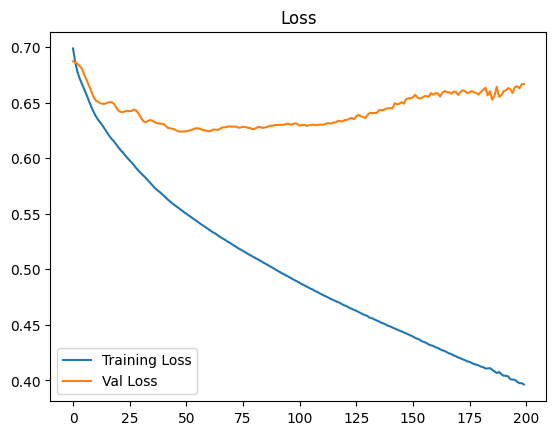

In [20]:
plt.plot(train_losses, label = "Training Loss")
plt.plot(val_losses, label = "Val Loss")
plt.title('Loss')
plt.legend()
plt.show()

In [21]:
#RNNbased, LSTMbased, GRUbased, BI_RNNbased, BI_LSTMbased, BI_GRUbased
train_losses = []
val_losses = []
BI_GRUmodel = BI_GRUbased().cuda()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(BI_GRUmodel.parameters(), lr=1e-3)
epoch(BI_GRUmodel, optimizer, loss_fn)

100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


Accuracy: 0.489815712900097
Precision: 0.5537327471181399
Recall: 0.5185811321896463
f1_score: 0.4091239921551536


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.513094083414161
Precision: 0.5225105384554204
Recall: 0.5214082024749629
f1_score: 0.5099178843866706


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.533462657613967
Precision: 0.5185519715931665
Recall: 0.5113026080905267
f1_score: 0.4686825354819839


100%|██████████| 1/1 [00:00<00:00, 37.72it/s]


Accuracy: 0.5431619786614937
Precision: 0.6034425686858655
Recall: 0.5094550845662764
f1_score: 0.3807507743787436


100%|██████████| 1/1 [00:00<00:00, 12.48it/s]


Accuracy: 0.5373423860329777
Precision: 0.6016260162601625
Recall: 0.502363771141569
f1_score: 0.35701089763285376


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.5363724539282251
Precision: 0.5537806919642857
Recall: 0.5014579740401198
f1_score: 0.3565807064820038


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.5363724539282251
Precision: 0.545879539030224
Recall: 0.5015960182747874
f1_score: 0.3584034619951257


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.5412221144519883
Precision: 0.5945351137487636
Recall: 0.5072293576593749
f1_score: 0.37474052391411106


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.5489815712900097
Precision: 0.6311467717717718
Recall: 0.5158561768176455
f1_score: 0.3951064965346516


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.565470417070805
Precision: 0.6362382629107981
Recall: 0.5351199661129769
f1_score: 0.44457912457912463


100%|██████████| 1/1 [00:00<00:00, 12.56it/s]

Accuracy: 0.5877788554801164
Precision: 0.626038592508513
Recall: 0.5629935554143596
f1_score: 0.5138718620923786



100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6081474296799224
Precision: 0.6186540384728514
Recall: 0.5915403467368612
f1_score: 0.5757270793777554


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6294859359844811
Precision: 0.6284267103580563
Recall: 0.6215451120994826
f1_score: 0.6202248707860836


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6333656644034917
Precision: 0.6320720571269143
Recall: 0.6324846449426644
f1_score: 0.6321610601427115


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6256062075654704
Precision: 0.6286543405928615
Recall: 0.628689373997761
f1_score: 0.625605855347332


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6314258001939864
Precision: 0.6360799878461012
Recall: 0.635504598953133
f1_score: 0.6313671913224789


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Accuracy: 0.635305528612997
Precision: 0.6375856655496182
Recall: 0.6378853892469214
f1_score: 0.6352777359626675


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]

Accuracy: 0.6333656644034917
Precision: 0.6325851707934214
Recall: 0.6331748661160026
f1_score: 0.6325356415478616



100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6440349175557711
Precision: 0.6421203949101844
Recall: 0.6387212187225803
f1_score: 0.6388102158774706


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6459747817652765
Precision: 0.6493154390345401
Recall: 0.6357012647121116
f1_score: 0.6327003694322846


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6362754607177498
Precision: 0.6456189039176591
Recall: 0.6226400108922574
f1_score: 0.6146946707526721


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Accuracy: 0.6285160038797284
Precision: 0.6439006432612571
Recall: 0.6123566609179752
f1_score: 0.5989349567980043


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6294859359844811
Precision: 0.650477051728868
Recall: 0.6120200599074158
f1_score: 0.5954620156949751


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6265761396702231
Precision: 0.6456678427419356
Recall: 0.609302668603068
f1_score: 0.593031183837514


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6314258001939864
Precision: 0.6495319966500812
Recall: 0.6147979637529878
f1_score: 0.6004658410429617


100%|██████████| 1/1 [00:00<00:00, 41.52it/s]


Accuracy: 0.6323957322987391
Precision: 0.6450155151787049
Recall: 0.6173602916704487
f1_score: 0.6066014608387489


100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


Accuracy: 0.6411251212415131
Precision: 0.6496876353064885
Recall: 0.6281353060421773
f1_score: 0.6214583978343535


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.646944713870029
Precision: 0.651846452866861
Recall: 0.6359168406402227
f1_score: 0.6321149050300359


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6517943743937924
Precision: 0.65475641300229
Recall: 0.6421023569634807
f1_score: 0.6398181423623782


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6498545101842871
Precision: 0.6506250804997424
Recall: 0.6415331608725909
f1_score: 0.6403037680106153


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6401551891367604
Precision: 0.6393241880810054
Recall: 0.6327512783274334
f1_score: 0.6319433819744141


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6459747817652765
Precision: 0.6457259202001769
Recall: 0.6383241051707966
f1_score: 0.6374604165522636


100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


Accuracy: 0.6498545101842871
Precision: 0.6502922031072134
Recall: 0.6418092493419261
f1_score: 0.6407648168792499


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6566440349175557
Precision: 0.6585793200788455
Recall: 0.6478737405827357
f1_score: 0.6464581299111918


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6537342386032978
Precision: 0.6576323806519628
Recall: 0.643637862697044
f1_score: 0.6410240655401946


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6498545101842871
Precision: 0.6541308240728344
Recall: 0.6393244531179086
f1_score: 0.6361630599798037


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.646944713870029
Precision: 0.6505125427118927
Recall: 0.6366070618135609
f1_score: 0.6335661112803568


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6498545101842871
Precision: 0.6533532004615372
Recall: 0.6397385858219116
f1_score: 0.637001926218516


100%|██████████| 1/1 [00:00<00:00, 13.33it/s]

Accuracy: 0.6498545101842871
Precision: 0.6528668995532212
Recall: 0.6400146742912469
f1_score: 0.6375449062726113



100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


Accuracy: 0.6508244422890398
Precision: 0.6540517633439451
Recall: 0.6409204713926961
f1_score: 0.6384147767126491


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6527643064985451
Precision: 0.6554672367945898
Recall: 0.6432842425342653
f1_score: 0.6412121282816972


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6488845780795345
Precision: 0.650606680411027
Recall: 0.6397990983631358
f1_score: 0.6379719085865052


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6508244422890398
Precision: 0.6525040650406504
Recall: 0.6418867810353696
f1_score: 0.6402205437597903


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Accuracy: 0.6479146459747818
Precision: 0.6498609804963813
Recall: 0.6386172127923513
f1_score: 0.6365900623108317


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6498545101842871
Precision: 0.6519687614997751
Recall: 0.6405668512299174
f1_score: 0.6385923209206894


100%|██████████| 1/1 [00:00<00:00, 41.51it/s]


Accuracy: 0.6498545101842871
Precision: 0.6521841596170241
Recall: 0.6404288069952497
f1_score: 0.6383352524766666


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6527643064985451
Precision: 0.6550212366250102
Recall: 0.6435603310036004
f1_score: 0.6417219957289846


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6527643064985451
Precision: 0.6548074023973858
Recall: 0.6436983752382681
f1_score: 0.6419722189888643


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Accuracy: 0.6547041707080504
Precision: 0.6560932768019383
Recall: 0.6462001906145048
f1_score: 0.6449367333513911


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6547041707080504
Precision: 0.6560932768019383
Recall: 0.6462001906145048
f1_score: 0.6449367333513911


100%|██████████| 1/1 [00:00<00:00, 37.72it/s]


Accuracy: 0.6566440349175557
Precision: 0.657981578183928
Recall: 0.6482878732867386
f1_score: 0.6471635730858469


100%|██████████| 1/1 [00:00<00:00, 33.33it/s]


Accuracy: 0.6605237633365665
Precision: 0.6619396083792368
Recall: 0.6523251943965387
f1_score: 0.6513769090459408


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6634335596508244
Precision: 0.6649495923203599
Recall: 0.6553186741702217
f1_score: 0.6544762677406426


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6605237633365665
Precision: 0.6615653204558377
Recall: 0.6526012828658739
f1_score: 0.6518209326200897


100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


Accuracy: 0.6595538312318138
Precision: 0.6602711507138066
Recall: 0.6518335299990923
f1_score: 0.6511522989586075


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6624636275460718
Precision: 0.6632706374085684
Recall: 0.6548270097727753
f1_score: 0.6542402282013723


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6634335596508244
Precision: 0.664387116348887
Recall: 0.6557328068742246
f1_score: 0.6551277713351475


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


Accuracy: 0.6653734238603298
Precision: 0.666630665226609
Recall: 0.6575444010771232
f1_score: 0.6569025105211934


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6692531522793405
Precision: 0.6701920782629444
Recall: 0.6618578106562585
f1_score: 0.6615034300156456


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6673132880698351
Precision: 0.6683195339830583
Recall: 0.6597701279840247
f1_score: 0.6593121174724013


100%|██████████| 1/1 [00:00<00:00, 13.42it/s]


Accuracy: 0.6702230843840931
Precision: 0.6716871803069053
Recall: 0.6624875192883726
f1_score: 0.6619802514849957


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6692531522793405
Precision: 0.6707548301932078
Recall: 0.6614436779522557
f1_score: 0.6608804524281939


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6692531522793405
Precision: 0.6705610648015075
Recall: 0.6615817221869232
f1_score: 0.6610909798999577


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6741028128031038
Precision: 0.6750420354684179
Recall: 0.6669389731021754
f1_score: 0.6667641445545773


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6721629485935985
Precision: 0.6726600654328208
Recall: 0.6652654231339445
f1_score: 0.665169683692686


100%|██████████| 1/1 [00:00<00:00, 13.29it/s]


Accuracy: 0.6741028128031038
Precision: 0.6748664054150338
Recall: 0.667077017336843
f1_score: 0.6669589293954776


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6731328806983511
Precision: 0.6739322503961965
Recall: 0.6660331760007261
f1_score: 0.6658704033343046


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6692531522793405
Precision: 0.6698474643423138
Recall: 0.6621338991255937
f1_score: 0.6619044734035546


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6711930164888458
Precision: 0.6718898573692551
Recall: 0.66408353756316
f1_score: 0.6638874383689295


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6750727449078564
Precision: 0.675974643423138
Recall: 0.6679828144382923
f1_score: 0.6678533682996797


100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


Accuracy: 0.6731328806983511
Precision: 0.6739322503961965
Recall: 0.6660331760007261
f1_score: 0.6658704033343046


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6741028128031038
Precision: 0.6748664054150338
Recall: 0.667077017336843
f1_score: 0.6669589293954776


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6760426770126091
Precision: 0.6765668757149055
Recall: 0.6693027442437445
f1_score: 0.6693202682666379


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6750727449078564
Precision: 0.6758002515245711
Recall: 0.6681208586729599
f1_score: 0.668046183374485


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6741028128031038
Precision: 0.6746969385658517
Recall: 0.6672150615715107
f1_score: 0.6671509281678774


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6741028128031038
Precision: 0.6752238794110402
Recall: 0.6668009288675079
f1_score: 0.6665665642541986


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Accuracy: 0.6760426770126091
Precision: 0.6774639757981052
Recall: 0.6686125230704063
f1_score: 0.6683520945534676


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6799224054316197
Precision: 0.6815679484117507
Recall: 0.6725117999455388
f1_score: 0.67232392575642


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6789524733268671
Precision: 0.6806433233191753
Recall: 0.6714679586094219
f1_score: 0.6712312270652034


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]

Accuracy: 0.6779825412221144


Precision: 0.6791305796135909
Recall: 0.6708382499773078
f1_score: 0.6707312380717847


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6799224054316197
Precision: 0.6809880061750386
Recall: 0.6729259326495416
f1_score: 0.6729060913705583


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6789524733268671
Precision: 0.6802476045313455
Recall: 0.671744047078757
f1_score: 0.6716260362089785


100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


Accuracy: 0.6799224054316197
Precision: 0.6813681475418955
Recall: 0.6726498441802063
f1_score: 0.6725207327496593


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6799224054316197
Precision: 0.6811748516861775
Recall: 0.6727878884148739
f1_score: 0.6727147848303885


100%|██████████| 1/1 [00:00<00:00, 39.98it/s]


Accuracy: 0.6818622696411252
Precision: 0.6830285397617069
Recall: 0.6748755710871077
f1_score: 0.6748884786955853


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6799224054316197
Precision: 0.6811748516861775
Recall: 0.6727878884148739
f1_score: 0.6727147848303885


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6808923375363725
Precision: 0.6821018225039619
Recall: 0.6738317297509908
f1_score: 0.6738022631958048


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Accuracy: 0.6838021338506305
Precision: 0.6845252157752157
Recall: 0.6772393422286769
f1_score: 0.6774216458592466


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6828322017458778
Precision: 0.6835960591133006
Recall: 0.67619550089256
f1_score: 0.6763417479083564


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6828322017458778
Precision: 0.6835960591133006
Recall: 0.67619550089256
f1_score: 0.6763417479083564


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6828322017458778
Precision: 0.6834261794605483
Recall: 0.6763335451272277
f1_score: 0.6765218642807456


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6789524733268671
Precision: 0.678647252121108
Recall: 0.6731244894254335
f1_score: 0.673436012267884


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Accuracy: 0.6828322017458778
Precision: 0.6824119253846334
Recall: 0.6772998547699011
f1_score: 0.6777080877692601


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6789524733268671
Precision: 0.6790626911554809
Recall: 0.6727103567214305
f1_score: 0.672921452881601


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6818622696411252
Precision: 0.6820192450849025
Recall: 0.6757038364951136
f1_score: 0.6759725575869073


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6818622696411252
Precision: 0.6814707371208286
Recall: 0.6762560134337842
f1_score: 0.6766418053165041


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6789524733268671
Precision: 0.678400221013393
Recall: 0.6734005778947687
f1_score: 0.6737656790569575


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6789524733268671
Precision: 0.6785207700101317
Recall: 0.673262533660101
f1_score: 0.6736021776369464


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Accuracy: 0.6789524733268671
Precision: 0.6790626911554809
Recall: 0.6727103567214305
f1_score: 0.672921452881601


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6818622696411252
Precision: 0.681598733367651
Recall: 0.6761179691991166
f1_score: 0.6764784668488203


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6808923375363725
Precision: 0.6800712171231071
Recall: 0.6757643490363378
f1_score: 0.6762086131435635


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6779825412221144
Precision: 0.6770264619101829
Recall: 0.6729089134973223
f1_score: 0.6733331297383549


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6808923375363725
Precision: 0.680288536259364
Recall: 0.6754882605670025
f1_score: 0.6758967567603722


100%|██████████| 1/1 [00:00<00:00, 41.57it/s]


Accuracy: 0.6847720659553831
Precision: 0.683861605762691
Recall: 0.6799397143808055
f1_score: 0.6804430071307248


100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


Accuracy: 0.6808923375363725
Precision: 0.6797066533035232
Recall: 0.6763165259750084
f1_score: 0.676800968075426


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]

Accuracy: 0.6799224054316197
Precision: 0.6789269141531322
Recall: 0.6749965961695561
f1_score: 0.6754521520146521



100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6808923375363725
Precision: 0.6804060731990133
Recall: 0.6753502163323348
f1_score: 0.6757368834131088


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6741028128031038
Precision: 0.6730343300110742
Recall: 0.6690096366221899
f1_score: 0.6693973843135159


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6770126091173618
Precision: 0.6758930779694553
Recall: 0.6721411606305406
f1_score: 0.672576988844712


100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


Accuracy: 0.6779825412221144
Precision: 0.6770264619101829
Recall: 0.6729089134973223
f1_score: 0.6733331297383549


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6770126091173618
Precision: 0.6762825992353362
Recall: 0.6715889836918701
f1_score: 0.6719562917969724


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6760426770126091
Precision: 0.6750303959606285
Recall: 0.6709592750597562
f1_score: 0.6713652570259354


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6779825412221144
Precision: 0.6769334880123743
Recall: 0.67304695773199
f1_score: 0.6734851953601955


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6818622696411252
Precision: 0.6812327703358572
Recall: 0.6765321019031194
f1_score: 0.6769605820227124


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Accuracy: 0.6828322017458778
Precision: 0.6825383836022134
Recall: 0.6771618105352335
f1_score: 0.677546562197225


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6750727449078564
Precision: 0.6739009460211464
Recall: 0.6701915221929744
f1_score: 0.6706104842732087


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6770126091173618
Precision: 0.6759818906473707
Recall: 0.6720031163958731
f1_score: 0.6724257855100341


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6808923375363725
Precision: 0.6800712171231071
Recall: 0.6757643490363378
f1_score: 0.6762086131435635


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6779825412221144
Precision: 0.6771251764194984
Recall: 0.6727708692626546
f1_score: 0.6731784260256499


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6789524733268671
Precision: 0.6778852099177641
Recall: 0.6740907990681069
f1_score: 0.6745434934162153


100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


Accuracy: 0.6799224054316197
Precision: 0.6789269141531322
Recall: 0.6749965961695561
f1_score: 0.6754521520146521


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6789524733268671
Precision: 0.6778852099177641
Recall: 0.6740907990681069
f1_score: 0.6745434934162153


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6799224054316197
Precision: 0.678837078174361
Recall: 0.6751346404042238
f1_score: 0.6756006864988559


100%|██████████| 1/1 [00:00<00:00, 39.95it/s]


Accuracy: 0.6789524733268671
Precision: 0.6779766281004527
Recall: 0.6739527548334392
f1_score: 0.6743931982096735


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6789524733268671
Precision: 0.6777995198727895
Recall: 0.6742288433027745
f1_score: 0.6746911691389341


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6828322017458778
Precision: 0.6817787092142742
Recall: 0.6781281201779068
f1_score: 0.6786223936810618


100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


Accuracy: 0.6818622696411252
Precision: 0.680660533635362
Recall: 0.6773603673111253
f1_score: 0.6778542414473734


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6799224054316197
Precision: 0.6786746180338857
Recall: 0.675410728873559
f1_score: 0.6758899380415646


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6838021338506305
Precision: 0.6826464492368383
Recall: 0.6793100057486914
f1_score: 0.679818544853182


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6876818622696411
Precision: 0.6866182804397907
Recall: 0.6832092826238239
f1_score: 0.6837471516647995


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6876818622696411
Precision: 0.6866182804397907
Recall: 0.6832092826238239
f1_score: 0.6837471516647995


100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


Accuracy: 0.6867119301648884
Precision: 0.6855840975767516
Recall: 0.6823034855223745
f1_score: 0.6828341897110857


100%|██████████| 1/1 [00:00<00:00, 37.72it/s]


Accuracy: 0.6886517943743938
Precision: 0.6876551538046412
Recall: 0.6841150797252731
f1_score: 0.6846599111009476


100%|██████████| 1/1 [00:00<00:00, 28.56it/s]


Accuracy: 0.6876818622696411
Precision: 0.6866182804397907
Recall: 0.6832092826238239
f1_score: 0.6837471516647995


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6867119301648884
Precision: 0.6855840975767516
Recall: 0.6823034855223745
f1_score: 0.6828341897110857


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6867119301648884
Precision: 0.6855060759883095
Recall: 0.6824415297570421
f1_score: 0.6829706678395343


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Accuracy: 0.6876818622696411
Precision: 0.6866182804397907
Recall: 0.6832092826238239
f1_score: 0.6837471516647995


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6867119301648884
Precision: 0.6856680286793617
Recall: 0.6821654412877068
f1_score: 0.6826951753445671


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6867119301648884
Precision: 0.6856680286793617
Recall: 0.6821654412877068
f1_score: 0.6826951753445671


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]

Accuracy: 0.6896217264791464
Precision: 0.6885196700116973
Recall: 0.6852969652960577
f1_score: 0.6858479211420387



100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6886517943743938
Precision: 0.6876551538046412
Recall: 0.6841150797252731
f1_score: 0.6846599111009476


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6896217264791464
Precision: 0.6887913522364773
Recall: 0.6848828325920546
f1_score: 0.6854309687261633


100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


Accuracy: 0.6867119301648884
Precision: 0.6855840975767516
Recall: 0.6823034855223745
f1_score: 0.6828341897110857


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


Accuracy: 0.6838021338506305
Precision: 0.6826464492368383
Recall: 0.6793100057486914
f1_score: 0.679818544853182


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6847720659553831
Precision: 0.683861605762691
Recall: 0.6799397143808055
f1_score: 0.6804430071307248


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6818622696411252
Precision: 0.680660533635362
Recall: 0.6773603673111253
f1_score: 0.6778542414473734


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6838021338506305
Precision: 0.6825690297358862
Recall: 0.6794480499833591
f1_score: 0.679957569663452


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6876818622696411
Precision: 0.6869006187161639
Recall: 0.6827951499198208
f1_score: 0.6833199786324786


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Accuracy: 0.6838021338506305
Precision: 0.6829137664346481
Recall: 0.6788958730446886
f1_score: 0.6793860653235654


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6828322017458778
Precision: 0.6816937784288026
Recall: 0.6782661644125745
f1_score: 0.6787657038318065


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6818622696411252
Precision: 0.6807413407390264
Recall: 0.6772223230764576
f1_score: 0.6777117849327914


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6857419980601358
Precision: 0.6848096426116308
Recall: 0.6809835557169224
f1_score: 0.6814988558352403


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6828322017458778
Precision: 0.6817787092142742
Recall: 0.6781281201779068
f1_score: 0.6786223936810618


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Accuracy: 0.6818622696411252
Precision: 0.680660533635362
Recall: 0.6773603673111253
f1_score: 0.6778542414473734


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


Accuracy: 0.6838021338506305
Precision: 0.6826464492368383
Recall: 0.6793100057486914
f1_score: 0.679818544853182


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6876818622696411
Precision: 0.6866182804397907
Recall: 0.6832092826238239
f1_score: 0.6837471516647995


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6857419980601358
Precision: 0.68455257649449
Recall: 0.6813976884209252
f1_score: 0.6819210201563142


100%|██████████| 1/1 [00:00<00:00, 43.41it/s]


Accuracy: 0.6857419980601358
Precision: 0.68455257649449
Recall: 0.6813976884209252
f1_score: 0.6819210201563142


100%|██████████| 1/1 [00:00<00:00, 13.14it/s]


Accuracy: 0.6857419980601358
Precision: 0.6846323648383146
Recall: 0.6812596441862575
f1_score: 0.6817828482589908


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6867119301648884
Precision: 0.6855060759883095
Recall: 0.6824415297570421
f1_score: 0.6829706678395343


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6857419980601358
Precision: 0.6846323648383146
Recall: 0.6812596441862575
f1_score: 0.6817828482589908


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6857419980601358
Precision: 0.68455257649449
Recall: 0.6813976884209252
f1_score: 0.6819210201563142


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6867119301648884
Precision: 0.6855060759883095
Recall: 0.6824415297570421
f1_score: 0.6829706678395343


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6876818622696411
Precision: 0.6865361232530937
Recall: 0.6833473268584914
f1_score: 0.6838844706491766


100%|██████████| 1/1 [00:00<00:00, 12.58it/s]


Accuracy: 0.6867119301648884
Precision: 0.6855840975767516
Recall: 0.6823034855223745
f1_score: 0.6828341897110857


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6867119301648884
Precision: 0.6855840975767516
Recall: 0.6823034855223745
f1_score: 0.6828341897110857


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Accuracy: 0.6857419980601358
Precision: 0.6847180436627324
Recall: 0.6811215999515899
f1_score: 0.6816421290189769


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6857419980601358
Precision: 0.6846323648383146
Recall: 0.6812596441862575
f1_score: 0.6817828482589908


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6886517943743938
Precision: 0.6875688204085719
Recall: 0.6842531239599408
f1_score: 0.6847980646973947


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6857419980601358
Precision: 0.6846323648383146
Recall: 0.6812596441862575
f1_score: 0.6817828482589908


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Accuracy: 0.6867119301648884
Precision: 0.6854339358833517
Recall: 0.6825795739917098
f1_score: 0.6831046161195439


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6876818622696411
Precision: 0.6866182804397907
Recall: 0.6832092826238239
f1_score: 0.6837471516647995


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6876818622696411
Precision: 0.6866182804397907
Recall: 0.6832092826238239
f1_score: 0.6837471516647995


100%|██████████| 1/1 [00:00<00:00, 41.42it/s]


Accuracy: 0.6857419980601358
Precision: 0.6844105588059151
Recall: 0.6816737768902605
f1_score: 0.6821897476880923


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6867119301648884
Precision: 0.6855840975767516
Recall: 0.6823034855223745
f1_score: 0.6828341897110857


100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


Accuracy: 0.6857419980601358
Precision: 0.68455257649449
Recall: 0.6813976884209252
f1_score: 0.6819210201563142


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6876818622696411
Precision: 0.6865361232530937
Recall: 0.6833473268584914
f1_score: 0.6838844706491766


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6886517943743938
Precision: 0.6875688204085719
Recall: 0.6842531239599408
f1_score: 0.6847980646973947


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6867119301648884
Precision: 0.6853676504443114
Recall: 0.6827176182263774
f1_score: 0.6832360408143465


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6876818622696411
Precision: 0.6865361232530937
Recall: 0.6833473268584914
f1_score: 0.6838844706491766


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Accuracy: 0.6876818622696411
Precision: 0.6865361232530937
Recall: 0.6833473268584914
f1_score: 0.6838844706491766


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6896217264791464
Precision: 0.6885196700116973
Recall: 0.6852969652960577
f1_score: 0.6858479211420387


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6876818622696411
Precision: 0.6864598946923403
Recall: 0.683485371093159
f1_score: 0.6840192644483363


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Accuracy: 0.6886517943743938
Precision: 0.6876551538046412
Recall: 0.6841150797252731
f1_score: 0.6846599111009476


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6867119301648884
Precision: 0.6855840975767516
Recall: 0.6823034855223745
f1_score: 0.6828341897110857


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6876818622696411
Precision: 0.6866182804397907
Recall: 0.6832092826238239
f1_score: 0.6837471516647995


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Accuracy: 0.6867119301648884
Precision: 0.6855840975767516
Recall: 0.6823034855223745
f1_score: 0.6828341897110857


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Accuracy: 0.6867119301648884
Precision: 0.6857578985557589
Recall: 0.6820273970530393
f1_score: 0.6825536182231895


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6847720659553831
Precision: 0.6836809035540822
Recall: 0.6802158028501406
f1_score: 0.6807304395881868


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6847720659553831
Precision: 0.6836809035540822
Recall: 0.6802158028501406
f1_score: 0.6807304395881868


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6876818622696411
Precision: 0.6867063951245853
Recall: 0.6830712383891562
f1_score: 0.6836073010620698


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6857419980601358
Precision: 0.6847180436627324
Recall: 0.6811215999515899
f1_score: 0.6816421290189769


100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


Accuracy: 0.6867119301648884
Precision: 0.6858537377109999
Recall: 0.6818893528183716
f1_score: 0.6824095117022282


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Accuracy: 0.6857419980601358
Precision: 0.6848096426116308
Recall: 0.6809835557169224
f1_score: 0.6814988558352403


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Accuracy: 0.6876818622696411
Precision: 0.6870067916579544
Recall: 0.6826571056851533
f1_score: 0.6831724933004528


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Accuracy: 0.6905916585838991
Precision: 0.6896422789299206
Recall: 0.6860647181628392
f1_score: 0.6866246468573279


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6876818622696411
Precision: 0.6870067916579544
Recall: 0.6826571056851533
f1_score: 0.6831724933004528


100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


Accuracy: 0.6876818622696411
Precision: 0.6869006187161639
Recall: 0.6827951499198208
f1_score: 0.6833199786324786


100%|██████████| 1/1 [00:00<00:00, 31.24it/s]


Accuracy: 0.6886517943743938
Precision: 0.687950315365863
Recall: 0.6837009470212702
f1_score: 0.6842302617078706


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Accuracy: 0.6905916585838991
Precision: 0.6897370878972435
Recall: 0.6859266739281716
f1_score: 0.6864848427653172


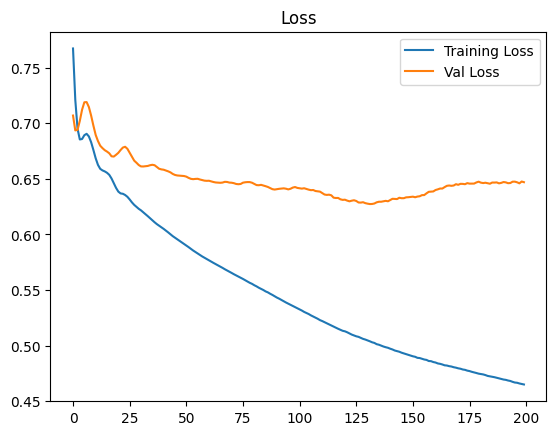

In [22]:
plt.plot(train_losses, label = "Training Loss")
plt.plot(val_losses, label = "Val Loss")
plt.title('Loss')
plt.legend()
plt.show()